# Studienarbeit: Machine Learning
#### Saniye Ogul und Johannes Horst

### Imports
- plotly
- matplotlib
- pandas
- numpy
- scikit-learn

In [1]:
# Importe
import pandas as pd
import numpy as np
import plotly.express as px
#%matplotlib widget
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

#Import Trainingmodel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#import graphviz
from sklearn import tree
from matplotlib.dates import DateFormatter
import datetime as dt
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import make_scorer, accuracy_score
import math
from collections import Counter
from sklearn.linear_model import LogisticRegression




#### Analyse des Datensatz

In [2]:
def to_time(s, fmat="%d-%m-%y %H:%M"): return dt.datetime.strptime(s, fmat)

def get_err(df, e, td_before=None, td_after=None): 
    dt_start = e[0]
    if td_before: dt_start = dt_start - td_before
        
    dt_end = e[1]
    if td_after: dt_end = dt_end + td_after
        
    return df.loc[(df["timestamp"] >= dt_start) & (df["timestamp"] < dt_end)]

In [3]:
ERRORS = [
#    Start,             Ende,              Fehlernummer
    (to_time("28-02-22 21:53"), to_time("01-03-22 02:00"), 1),
    (to_time("23-03-22 14:54"), to_time("23-03-22 15:24"), 2),
    (to_time("30-05-22 12:00"), to_time("02-06-22 06:18"), 3),
]

E1 = ERRORS[0]
E2 = ERRORS[1]
E3 = ERRORS[2]

In [4]:
def read_data_withLables():
    df                 = pd.read_csv('dataset_train.csv')
    df['timestamp']    = pd.to_datetime(df['timestamp'])
    #df.set_index("timestamp", verify_integrity=True, inplace=True)

    exclude            = ["gpsLong", "gpsLat", "gpsSpeed", "gpsQuality"]
    df                 = df[[c for c in df.columns if c not in exclude]]

    df["Error"]        = 0
    for e_start, e_end, e_nr in ERRORS: df.loc[(df["timestamp"] >= e_start) & (df["timestamp"] < e_end), "Error"] = e_nr
    df["isError"]      = df["Error"] != 0
    return df

df = read_data_withLables()

##### Visualisierung der Betriebszeiten:

In [5]:
df["start_stop"]   = 0
df.loc[df["timestamp"].diff(1).dt.total_seconds() != 1, "start_stop"] = 1
df.loc[df[df["start_stop"]==1].index[1:] - 1, "start_stop"]           = 2
df.loc[df.iloc[-1].name, "start_stop"]                                = 2


df_start            = df[df["start_stop"] == 1].reset_index().rename(columns={"timestamp":"start"})
df_stop             = df[df["start_stop"] == 2].reset_index().rename(columns={"timestamp":"stop"})

df_sp               = pd.concat([df_start["start"], df_stop["stop"]], axis=1)
df_sp["duration"]   = df_sp["stop"] - df_sp["start"]
df_series           = df_sp.copy()
df_series["values"] = df_sp["duration"].dt.total_seconds().astype(int)

df_sp["Error"]      = 0
df_err = pd.DataFrame(ERRORS, columns=("start", "stop", "Error"))
df_err["duration"] = df_err["stop"] - df_err["start"]
df_sp  = pd.concat([df_sp, df_err]).reset_index(drop=True)

df_sp["start_time"] = pd.to_datetime(df_sp["start"].dt.strftime("02.02.2022 %H:%M:%S"), format="%d.%m.%Y %H:%M:%S")
df_sp["start_date"] = df_sp["start"].dt.date
df_sp["stop_time"]  = df_sp["start_time"] + df_sp["duration"]
df_sp["text"]       = df_sp["start"].dt.strftime("%d.%m.%Y %H.%M.%S") + " - " + df_sp["stop"].dt.strftime("%d.%m.%Y %H.%M.%S")
                                                 
px.timeline(df_sp, x_start="start_time", x_end="stop_time", y="start_date", color="Error", height=1200, hover_name="text")

Die obrige Abbildung zeigt die Betriebszeiten an der y-Achse sind die Tage aufgezeigt und auf der X-Achse die Betreibszeit.
Die Fehler wurden Farbig hervorgehoben.

In [6]:
#make some space on ram
del [[df_sp]]

##### Korrelation der Daten mit Fehlern

In [7]:
ft_cols    = [c for c in df.columns if c not in ["timestamp", "isError", "Error", "start_stop"]]
df_corr_ft = df[ft_cols].copy()
df_corr_lb = df[["Error", "isError"]].copy()

df_corr_lb["IsError1"] = df_corr_lb["Error"] == 1
df_corr_lb["IsError2"] = df_corr_lb["Error"] == 2
df_corr_lb["IsError3"] = df_corr_lb["Error"] == 3

df_corr = pd.DataFrame({e:df_corr_ft.corrwith(df_corr_lb[e]) for e in ["isError", "IsError1", "IsError2", "IsError3"]})

In [8]:
px.bar(df_corr.unstack().reset_index(), x="level_1", y=0, color="level_0", barmode="group")

Die obere Abbildung zeigt die Die Korrelation der Einzelnen Sensordaten zu den Fehlern.

Die 3 Aussagekräftigsten Sensoren für jeden Fehler sind:

In [9]:
eralg = df_corr["isError"].abs().sort_values(ascending=False)
er1 = df_corr['IsError1'].abs().sort_values(ascending=False)
er2 = df_corr['IsError2'].abs().sort_values(ascending=False)
er3 = df_corr['IsError3'].abs().sort_values(ascending=False)

print(f'Fehler 1: \n{er1[:3]}\n\nFehler 2: \n{er2[:3]}\n\nFehler 3: \n{er3[:3]}\n\nAllgemein: \n{eralg[:3]}')

Fehler 1: 
LPS                0.357046
TP3                0.212710
Oil_temperature    0.120653
Name: IsError1, dtype: float64

Fehler 2: 
Reservoirs         0.003368
Oil_temperature    0.003248
LPS                0.001028
Name: IsError2, dtype: float64

Fehler 3: 
Reservoirs         0.144370
Oil_temperature    0.044362
Motor_current      0.013031
Name: IsError3, dtype: float64

Allgemein: 
Reservoirs    0.115827
LPS           0.084777
TP3           0.059212
Name: isError, dtype: float64


##### Visualisierung Aller Daten

In [10]:
# a function that plots every column in a dataframe in a single plot using matplotlib in subplots
def plot_df_all_columns(df, start, end):
    # Create a new dataframe with the data between start and end timestamps
    mask = (df['timestamp'] > start) & (df['timestamp'] <= end)
    df_plot = df.loc[mask]
    # Create a matplotlib figure
    fig, axs = plt.subplots(df_plot.columns.size, 1, figsize=(20, 40))

    i = 0
    for col in df_plot.columns:
        axs[i].plot(df_plot['timestamp'], df_plot[col])
        axs[i].set(xlabel='timestamp', ylabel=col, title=col)
        #display 20 x-axis labels
        axs[i].xaxis.set_major_locator(plt.MaxNLocator(20))
        axs[i].grid()
        formatter = DateFormatter('%H:%M:%S')
        fig1 = plt.gcf()
        fig1.axes[0].xaxis.set_major_formatter(formatter)
        i = i + 1

    fig.tight_layout()
    plt.show()

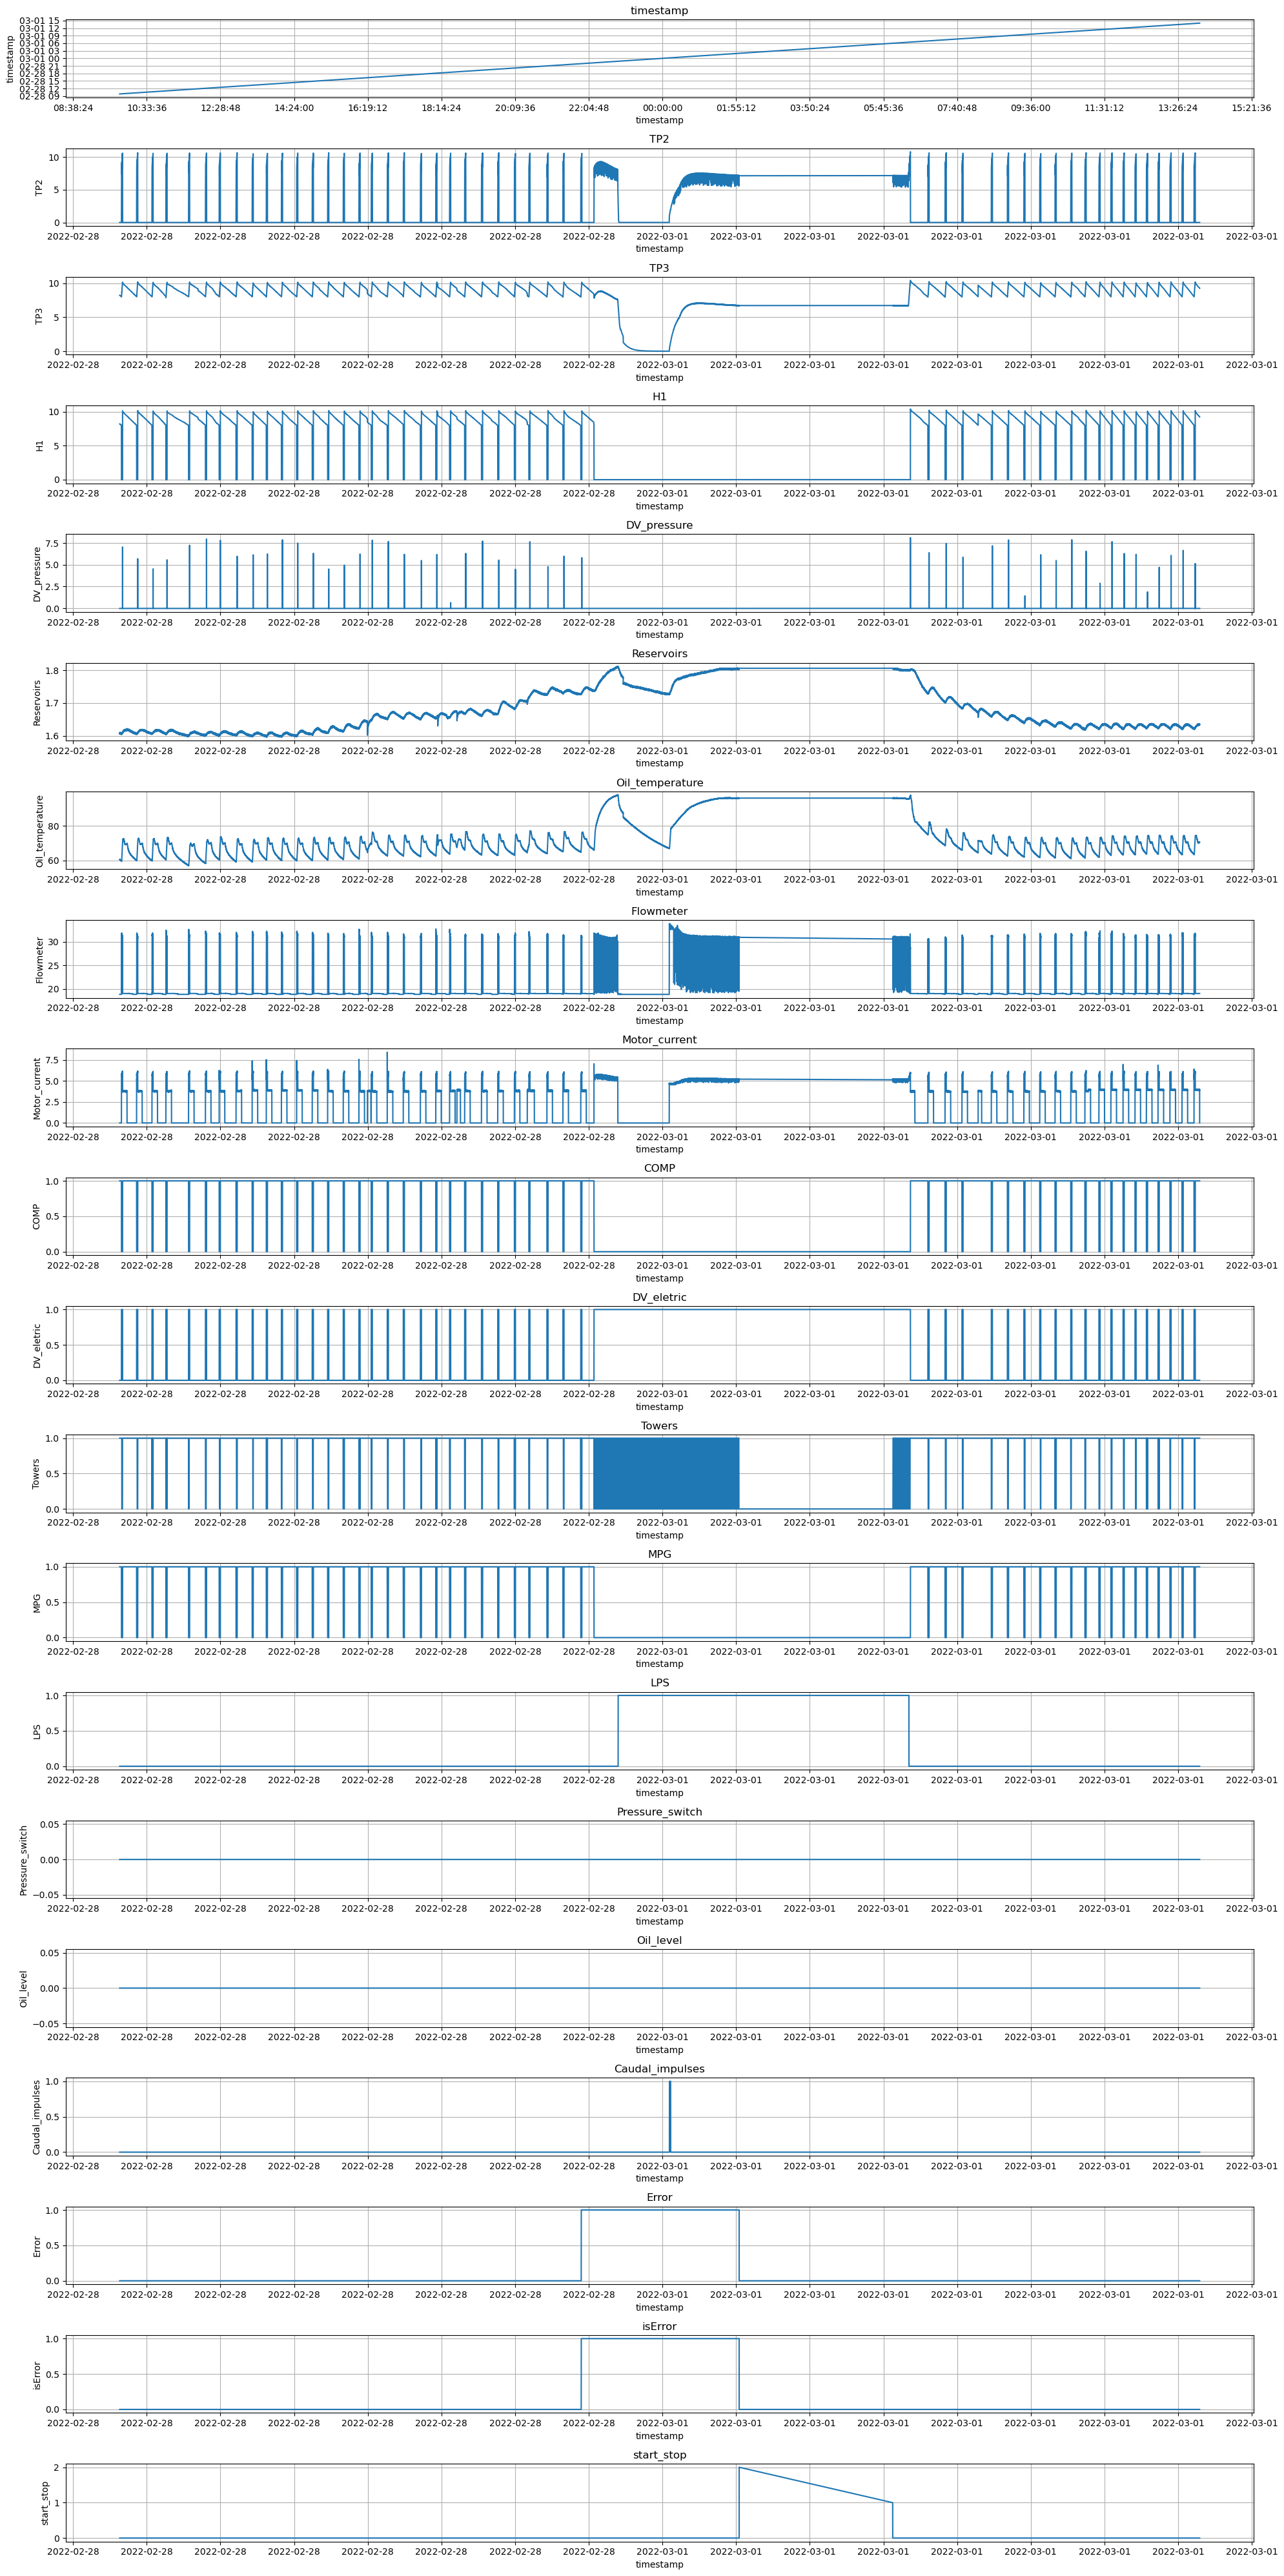

In [11]:
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

s = err_1_start - dt.timedelta(hours=3*4, seconds=100)
e = err_1_end   + dt.timedelta(hours=3*4)
plot_df_all_columns(df, s, e)

### Aufgabe 1 (Klassifikation des Systemzustands)
Erstellung eines binären Klassifikationsmodell zur Vorhersage des aktuellen Zutands der APU (Air Production Unit) auf Basis der Sensordaten. Soll differenziert werden ob APU in Ordnung oder nicht ist (binäre Klassifikation)
zu verwendene Verfahren:
- einen nicht-parametrisierten Modellansatz,
- einen parametrisierten Modellansatz,
- ein Verfahren aus dem Bereich des Ensemble Learning.

Trainigsdatensatz erstellen z.B. durch geeignete Datentransformationen, Feature Engineering und ggf. Feature Extraction. Sequentielle Struktur der Daten soll berücksichtigt werden.
Wenden Sie zur Modellerstellung (in dieser und den folgenden Aufgaben) geeignete Maßnahmen und Techniken an, damit die resultierenden Modelle eine moglichst hohe Gute aufweisen und beurteilen Sie diese anhand geeigneter Kriterien. Modularisieren und automatisieren Sie Ihren Workflow, damit die einzelnen Schritte in den folgenden Aufgaben ggf.
wiederverwendet werden konnen. Achten Sie darauf, dass Ihre Modelle auf unbekannte Daten angewendet werden konnen, die ggf. fehlende Werte enthalten, auch wenn der gegebene Datensatz keine fehlenden Werte enthalt. Welche Features erweisen sich als besonders aussagekräftig für die gegebene Aufgabenstellung?

- **TP2** - Druck am Kompressor (bar).
- **TP3** - An der Pneumatikzentrale erzeugter Druck (bar).
- **H1** - Ventil, das aktiviert wird, wenn der vom Druckschalter der Steuerung abgelesene Druck über dem Betriebsdruck von 10,2 bar (bar) liegt.
- **DV_pressure** - Druck, der durch den Druckabfall entsteht, wenn die Lufttrockentürme das Wasser. Wenn er gleich Null ist, arbeitet der Kompressor unter Last (bar).
- **Reservoirs** - Druck in den auf den Zügen installierten Luftbehältern (bar).
- **Oil_Temperature** - Temperatur des im Kompressor vorhandenen Öls (°C).
- **Durchflussmesser** - Der Luftdurchfluss wurde an der pneumatischen Schalttafel gemessen (m^3
/h).
- **Motor_Current** - Strom des Motors, der die folgenden Werte aufweisen sollte: (i) nahe 0 A, wenn der (ii) nahe bei 4 A, wenn der Kompressor im Leerlauf arbeitet, und (iii) nahe bei 7 A, wenn der Kompressor der Kompressor unter Last arbeitet (A);
- **COMP** - Elektrisches Signal des Lufteinlassventils des Kompressors. Es ist aktiv, wenn der Kompressor keine Luft ansaugt am Kompressor, d.h. der Kompressor schaltet ab oder arbeitet entlastet.
- **DV_electric** - Elektrisches Signal, das das Auslassventil des Verdichters steuert. Wenn es aktiv ist, bedeutet es, dass der Kompressor unter Last arbeitet, wenn es nicht aktiv ist, bedeutet es, dass der Kompressor ausgeschaltet oder entlastet ist.
- **TOWERS** - Signal, das festlegt, welcher Turm die Luft trocknet und welcher Turm die der Luft entzogene Feuchtigkeit abführt. Wenn es nicht aktiv ist, bedeutet es, dass Turm eins in Betrieb ist, wenn es aktiv ist, bedeutet es, fass Turm zwei in Betrieb ist.
- **MPG** - Ist für die Aktivierung des Einlassventils verantwortlich, um den Kompressor unter Last zu starten, wenn der Druck in der der APU unter 8,2 bar liegt. Folglich aktiviert er den Sensor COMP, der das gleiche Verhalten wie der MPG-Sensor.
- **LPS** - Signal aktiviert, wenn der Druck niedriger als 7 bar ist.
- **Pressure_switch** - Signal, das aktiviert wird, wenn ein Druck am Vorsteuerventil festgestellt wird.
- **Oil_Level** - Der Ölstand am Verdichter ist aktiv (gleich eins), wenn der Ölstand unter den erwarteten
Werten liegt.
- **Caudal_impulses** - Vom Durchflussmesser erzeugtes Signal, das den Luftdurchfluss pro Sekunde.


Was die GPS-Informationen betrifft, so wurde der Zug mit einer sekundären GPS-Antenne ausgestattet, um Folgendes zu erfassen
folgenden Daten:
- **gpsLong** - Längengrad-Position (°).
- **gpsLat** - Position des Breitengrades (°).
- **gpsSpeed** - Geschwindigkeit (km/h).
- **gpsQuality** - Signalqualität.

!!!
Bei der APU handelt es sich um eine Systemkomponente des Zugs, die im laufenden Betrieb ver-
schiedene wichtige Funktionen erf ̈ullt, und deren Ausfall eine sofortige Außerbetriebnahme und
Reparatur erforderlich macht. Weiterhin werden Angaben zu drei St ̈orungsf ̈allen gemacht, die
sich w ̈ahrend des o.g. Betrachtungszeitraums ergeignet haben. Diese k ̈onnen verwendet werden,
um geeignete Zielvariablen f ̈ur Methoden des Supervised Learning abzuleiten

In [12]:
# Daten einlesen
df = pd.read_csv('dataset_train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Zeiterfassung der Störungsfälle (für eigene Labels)
**Fall 1:**
- 28.2-1.03: 22:12:00 - 6:27:00

**Fall 2:**
- 24.03: 11:15:00 - 15:08:00

**Fall 3:**
- 30.05-02.06: 04:00:00 - 07:40:00 



In [13]:
#set labels for errors again in single column
df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)


In [14]:
analog_sensors = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_Temperature', 'Flowmeter', 'Motor_Current']
digitial_sensors = ['COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

In [15]:
from collections import Counter


class FeatureGeneration:
    """
    Class for feature generation
    """

    def yfft(self, y):
        """
        Compute the yFFT of a signal

        Parameters
        ----------
        y : array
            Signal

        Returns
        -------
        yfft : array
            yFFT
        """
        hanning = np.hanning(len(y))
        yf = 4*np.abs(np.fft.rfft(y*hanning))/len(y)
        return yf

    def xfft(self, blocksize, duration):
        """
        Compute the xFFT of a signal

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        duration : float
            Duration of a block in seconds

        Returns
        -------
        xfft : array
            xFFT
        """
        return np.fft.rfftfreq(blocksize, duration)

    def fourier(self, blocksize, max_freq, series, name):
        """
        Compute the Fourier transform of a signal

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        max_freq : float
            Maximum frequency to consider
        series : array
            Signal
        name : str
            Name of the signal

        Returns
        -------
        df : DataFrame
            Fourier transform
        """

        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        X_f = self.xfft(blocksize, 1)
        X_f = X_f[X_f<max_freq]
        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]
            # iserr    = df_block['Label'].sum() > BLOCKSIZE/2
            fft_amp  = self.yfft(sr_block)[:len(X_f)]
            # block_data = {'iserr': iserr}
            data.append({f'{name}_{j}':amp for j,amp in enumerate(fft_amp)})

        return pd.DataFrame(data)

    def getError(self, blocksize, series, name, label_most_common=True):
        """
        Compute the errors of a series in blocks

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        series : array
            Error Series
        name : str
            Name of the Error column in the resulting DataFrame
        label_most_common : bool, optional
            If True, the most common value in the block is used as label. If False, the mean is used. The default is True.

        Returns
        -------
        df : DataFrame
            Error Series
        """
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            #iserr    = sr_block.sum() > blocksize/2
            if(label_most_common):
                iserr = Counter(sr_block).most_common(1)[0][0]
            else:
                iserr = sr_block.mean()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':iserr})

        return pd.DataFrame(data)

    def getMean(self, blocksize, series, name):
        """
        Compute the mean of a series in blocks

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        series : array
            Series
        name : str
            Name of the column in the resulting DataFrame

        Returns
        -------
        df : DataFrame
            Mean Series
        """
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            mean    = sr_block.mean()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':mean})

        return pd.DataFrame(data)

    def countPeaks(self, blocksize, series, name):
        """
        Compute the number of peaks of a series in blocks

        Parameters
        ----------
        blocksize : int
            Number of samples in a block
        series : array
            Series
        name : str
            Name of the column in the resulting DataFrame

        Returns
        -------
        df : DataFrame
            Number of peaks
        """
        #number of blocks
        nblocks = int(len(series)/blocksize)

        data = []

        for i in range(nblocks):
            sr_block = series[i*blocksize:(i+1)*blocksize]

            count    = sr_block[sr_block > 0.5].count()
            # block_data = {'iserr': iserr}
            data.append({f'{name}':count})

        return pd.DataFrame(data)

    def getFeatures(self, df, blocksize = 700, max_freq = 1000, label_most_common = True):
        """
        Compute the features of a DataFrame

        Parameters
        ----------
        df : DataFrame
            DataFrame containing the signals
        blocksize : int, optional
            Number of samples in a block. The default is 700.
        max_freq : int, optional
            Maximum frequency to consider. The default is 1000.
        label_most_common : bool, optional
            If True, the most common value in the block is used as label. If False, the mean is used. The default is True.

        Returns
        -------
        df_features : DataFrame
            DataFrame containing the features
        """
        df_features = pd.DataFrame()

        blocks = blocksize

        tp3 = self.fourier(blocks,max_freq, df['TP3'], 'TP3')
        oil = self.fourier(blocks, max_freq, df['Oil_temperature'], 'Oil')
        res = self.fourier(blocks, max_freq, df['Reservoirs'], 'Res')
        motCurr = self.fourier(blocks, max_freq, df['Motor_current'], 'MotCurr')
        h1 = self.fourier(blocks, max_freq, df['H1'], 'H1')
        LPS = self.getMean(blocks, df['LPS'], 'LPS')
        DV_pressure_peaks = self.countPeaks(blocks, df['DV_pressure'], 'DV_pressure_peaks')

        errors = self.getError(blocks, df['Label'], 'Error', label_most_common)

        df_features = pd.concat([df_features, tp3, oil,errors, res, motCurr, h1, LPS, DV_pressure_peaks], axis=1)
        return df_features

In [16]:
class MetroBinaryClassifier:
    """
    Class for the binary classification of metro data

    Parameters
    ----------
    use_shortened : bool, optional
        If True, the shortened dataset is used. The default is False.

    n_components : float, optional
        Number of components to keep in the PCA. The default is 0.95.

    window_size : int, optional
        Size of the window for the rolling operations. The default is 60.

    test_size : float, optional
        Size of the test set. The default is 0.3.

    random_state : int, optional
        Random state for all random_state operations. The default is 0.

    max_depth : int, optional
        Maximum depth of the decision tree. The default is 7.

    min_samples_leaf : int, optional
        Minimum number of samples in a leaf. The default is 10.

    excluded_columns : list, optional
        List of columns to exclude from the dataset. The default is []. 
    """

    def __init__(self, use_shortened: False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=[]):
        self.n_components = n_components
        self.windowSize = window_size
        self.test_size = test_size
        self.random_state = random_state
        self.excluded_columns = excluded_columns
        self.use_shortened = use_shortened

        self.scaler = None
        self.pca = None

        self.feature_columns = None

        #Dataset:
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

        #classifiers
        self.decision_tree = None
        self.random_forest = None
        self.linear_SVM = None
        self.naive_bayes = None
        self.linear_discriminant_analysis = None

        #regressions
        self.polyreg_scaled = None
        self.logistic_regression = None
        self.linear_regression = None


    def prepareFourier(self, data: DataFrame, blocksize = 700, max_freq = 1000, stratify = True, label_most_common = True):
        """
        Prepare the data with the Fourier transform

        Parameters
        ----------
        data : DataFrame
            DataFrame containing the signals
        blocksize : int, optional
            Number of samples in a block. The default is 700.
        max_freq : int, optional
            Maximum frequency to consider. The default is 1000.
        stratify : bool, optional
            If True, the train and test sets are stratified. The default is True.
        label_most_common : bool, optional
            If True, the most common value in the block is used as label. If False, the mean is used. The default is True.
        """
        featureGenerator = FeatureGeneration()
        df_features = featureGenerator.getFeatures(data, blocksize = blocksize, max_freq = max_freq, label_most_common = label_most_common)
        X = df_features.drop('Error', axis=1)
        y = df_features['Error']

        s = None
        if stratify:
            s=y


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=s)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        return X_train, X_test, y_train, y_test
        


    def sliding_window(self, data: DataFrame, window_size = 60, step_size=None, label_func = None, excluded_columns = ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']):
        """
        Creates a sliding window of size window_size for each column in data.
        Performs the following operations on each column:
        - mean
        - std
        - min
        - max

        Parameters
        ----------
        data : DataFrame
            The DataFrame that should be transformed.

        window_size : int, optional
            The size of the sliding window. The default is 60.

        excluded_columns : list, optional
            A list of columns that should be excluded from the sliding window. The default is ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'].

        Returns
        -------
        df_rolling : DataFrame
            The transformed DataFrame.
        """
        columns = data.columns
        columns  = [x for x in columns if x not in excluded_columns]
        operations = ['mean', 'std', 'min', 'max', 'var']
        if(step_size == None):
            step_size = window_size

        #generate a dict, where the keys are the column names and the values are the operations that should be performed on the column
        operations_dict = {}
        for column in columns:
            operations_dict[column] = operations

        def mostFrequent(row):
            return Counter(row).most_common(1)[0][0]

        if(label_func == None):
            operations_dict['Label'] = [mostFrequent]
        else:
            operations_dict['Label'] = [label_func]

        df_rolling = data.rolling(window_size,center=True,step=window_size).agg(operations_dict)

        #drop all columns that have NaN values
        df_rolling = df_rolling.dropna()

        #flatten df_rolling
        df_rolling.columns = ['_'.join(col) for col in df_rolling.columns]

        #rename Label_<opaeration> to Label
        if(label_func == None):
            df_rolling = df_rolling.rename(columns={'Label_mostFrequent': 'Label'})
        else:
            name = "Label_"
            #check if the label_func is a string
            if(isinstance(label_func, str)):
                name += label_func

            #check if the label_func is a function
            elif(callable(label_func)):
                name += label_func.__name__

            #if the label_func is neither a string nor a function, raise an exception
            else:
                raise Exception("label_func is not a string or a function")

            df_rolling = df_rolling.rename(columns={name: 'Label'})
        
        return df_rolling
    
    def scale(self, train, test):
        """
        Scale the data using StandardScaler
        Fits the scaler on the training data and transforms the training and test data.

        Parameters
        ----------
        train : DataFrame
            The training data.

        test : DataFrame
            The test data.

        Returns
        -------
        train_rescaled : DataFrame
            The rescaled training data.
        """
        self.scaler = MinMaxScaler()
        train_rescaled = self.scaler.fit_transform(train)
        test_rescaled = self.scaler.transform(test)

        return train_rescaled, test_rescaled
    
    def performPca(self, train, test):
        """
        Perform PCA on the data.
        Fits the PCA on the training data and transforms the training and test data.
        This is done to reduce the dimensionality of the data.
        This will slightly reduce the accuracy of the model, but will increase the speed of the model.
        Uses the n_components parameter given by in the constructor of the class to determine the number of components.
        (if a float is given, the number of components is determined by the explained variance)

        Parameters
        ----------
        train : DataFrame
            The training data.

        test : DataFrame
            The test data.

        Returns
        -------
        train_pca : DataFrame
            The PCA transformed training data.

        test_pca : DataFrame
            The PCA transformed test data.
        """
        self.pca = PCA(n_components=self.n_components,random_state=self.random_state)
        train_pca = self.pca.fit_transform(train)
        test_pca = self.pca.transform(test)

        return train_pca, test_pca

    
    def prepareData(self, dataFrame, do_scale=True, do_pca=True,do_sliding=True, label_func=None):
        """
        Prepare the data for the model.
        This includes(if desired):
        - sliding window
        - scaling
        - PCA

        Parameters
        ----------
        dataFrame : DataFrame
            The DataFrame that should be prepared.

        do_scale : bool, optional
            Whether the data should be scaled. The default is True.

        do_pca : bool, optional
            Whether PCA should be performed on the data. The default is True.

        Returns
        -------
        X_train : DataFrame
            The training data.

        X_test : DataFrame
            The test data.

        y_train : DataFrame
            The training labels.

        y_test : DataFrame
            The test labels.
        """

        data = dataFrame

        if(self.use_shortened):
            data = self.shorten(dataFrame)

        if(do_sliding):
            data_prepared = self.sliding_window(data, window_size=self.windowSize, excluded_columns=self.excluded_columns,label_func=label_func)
        else:
            data_prepared = data

        y = data_prepared['Label']

        if(not do_sliding):
            ex = self.excluded_columns
            ex.remove('Label')
            data_prepared = data_prepared.drop(columns=ex, axis=1)
            
        data_prepared.drop(['Label'], axis=1, inplace=True)

        X = data_prepared

        self.feature_columns = X.columns

        print(self.feature_columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)

        
        if(do_scale):
            X_train, X_test = self.scale(X_train, X_test)

        if(do_pca):
            X_train, X_test = self.performPca(X_train, X_test)

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        return X_train, X_test, y_train, y_test

    def prepareDataManual(self, dataFrame, do_scale=True, do_pca=True, scatter=False, segments=5, label_func=None):
        """
        Manual data preparation.
        The data for each error and normal opeation is split into a number of segments.
        The segments are then equally distributed over the train and test data.

        Parameters
        ----------
        dataFrame : DataFrame
            The DataFrame that should be prepared.

        do_scale : bool, optional
            Whether the data should be scaled. The default is True.

        do_pca : bool, optional
            Whether PCA should be performed on the data. The default is True.

        scatter : bool, optional
            Whether the data should be scattered over the train and test data. The default is False.

        segments : int, optional
            The number of segments the data should be split into. The default is 5.

        Returns
        -------
        X_train : DataFrame
            The training data.

        X_test : DataFrame
            The test data.

        y_train : DataFrame
            The training labels.

        y_test : DataFrame
            The test labels.
        """

        #this data preperation uses manually selected train end test data instead of the train_test_split function
        #this is done so we can still use the sliding window with a step size of 1

        #the test slices are always connected to each other
        #both train and test should have date for all 3 errors and about the same ammount of normal operation present
        
        #get the indices of the errors starts and ends
        err_1_start_index = df.index[df['timestamp'] == err_1_start].tolist()[0]
        err_1_end_index = df.index[df['timestamp'] == err_1_end].tolist()[0]
        err_2_start_index = df.index[df['timestamp'] == err_2_start].tolist()[0]
        err_2_end_index = df.index[df['timestamp'] == err_2_end].tolist()[0]
        err_3_start_index = df.index[df['timestamp'] == err_3_start].tolist()[0]
        err_3_end_index = df.index[df['timestamp'] == err_3_end].tolist()[0]

        test_df = pd.DataFrame()
        train_df = pd.DataFrame()

        if(scatter):
            #device each error in n segments for both train and test

            #get the lenght of each error
            err_1_len = err_1_end_index - err_1_start_index
            err_2_len = err_2_end_index - err_2_start_index
            err_3_len = err_3_end_index - err_3_start_index

            #split the errors in n*2 segments and iterate over them. add every even segment to the test data and every odd segment to the train data
            for i in range(0, segments):
                from_idx_1 = int(err_1_start_index + err_1_len/segments * i     )
                to_idx_1   = int(err_1_start_index + err_1_len/segments * (i+1) )
                from_idx_2 = int(err_2_start_index + err_2_len/segments * i     )
                to_idx_2   = int(err_2_start_index + err_2_len/segments * (i+1) )
                from_idx_3 = int(err_3_start_index + err_3_len/segments * i     )
                to_idx_3   = int(err_3_start_index + err_3_len/segments * (i+1) )
                if(i % 2 == 0):
                    #add to test
                    test_df = test_df.append(self.sliding_window(df[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    test_df = test_df.append(self.sliding_window(df[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    test_df = test_df.append(self.sliding_window(df[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                else:
                    #add to train
                    train_df = train_df.append(self.sliding_window(df[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(df[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(df[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))

            #add the normal operation data to the train and test data
            before_err_1 = df[0 : err_1_start_index-1]
            before_err_2 = df[err_1_end_index+1 : err_2_start_index-1]
            before_err_3 = df[err_2_end_index+1 : err_3_start_index-1]

            #add the normal operation data to the train and test data
            for i in range(0,segments):
                from_idx_1  = int(before_err_1.shape[0]/segments * i        )
                to_idx_1    = int(before_err_1.shape[0]/segments * (i+1)    )
                from_idx_2  = int(before_err_2.shape[0]/segments * i        )
                to_idx_2    = int(before_err_2.shape[0]/segments * (i+1)    )
                from_idx_3  = int(before_err_3.shape[0]/segments * i        )
                to_idx_3    = int(before_err_3.shape[0]/segments * (i+1)    )

                if(i % 2 == 0):
                    #add to test
                    test_df = test_df.append(self.sliding_window(before_err_1[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns,step_size=1))
                    test_df = test_df.append(self.sliding_window(before_err_2[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns,step_size=1))
                    test_df = test_df.append(self.sliding_window(before_err_3[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns,step_size=1))
                else:
                    #add to train
                    train_df = train_df.append(self.sliding_window(before_err_1[from_idx_1:to_idx_1],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(before_err_2[from_idx_2:to_idx_2],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))
                    train_df = train_df.append(self.sliding_window(before_err_3[from_idx_3:to_idx_3],window_size=self.windowSize, excluded_columns=self.excluded_columns, step_size=1))

            #reorder the dfs by index
            train_df = train_df.sort_index()
            test_df = test_df.sort_index()

            #get labels
            self.y_train = train_df['Label']
            self.y_test = test_df['Label']
            
            train_df = train_df.drop(['Label'], axis=1)
            test_df = test_df.drop(['Label'], axis=1)

            #get the features
            self.X_train = train_df
            self.X_test = test_df
            
            return self.X_train, self.X_test, self.y_train, self.y_test

    
    def evalModels(self):
        """
        Evaluate the models.
        Prints a Plotly interactive Bar chart for each fitted model that shows the precision, recall and f1 score for each class.
        """

        calssifiers = [self.decision_tree, self.random_forest, self.linear_regression, self.linear_SVM, self.naive_bayes, self.linear_discriminant_analysis, self.logistic_regression]


        results = []
        clfs = []
        precison = {}
        recall = {}
        f1_score = {}


        for label in self.y_test.unique():
            precison[str(label)] = []
            recall  [str(label)] = []
            f1_score[str(label)] = []


        for classifier in calssifiers:
            if(classifier is not None):
                y_true, y_pred = self.y_test, classifier.predict(self.X_test)
                evaluation = classification_report(y_true, y_pred, output_dict=True)

                clfs.append(classifier.__class__.__name__)
                    
                for label in self.y_test.unique():

                    precison[str(label)].append(evaluation[str(label)]['precision'])
                    recall  [str(label)].append(evaluation[str(label)]['recall'])
                    f1_score[str(label)].append(evaluation[str(label)]['f1-score'])

        print(precison, recall, f1_score)

        print(results)
        #make a plot with plotly, where on the x axis are  the classifiers, each classifier has bar for classes precison, recall and f1-score

        data = []

        for label in self.y_test.unique():
            data.append(go.Bar(name ='[' + str(label) + '] precision',    x=clfs, y=precison[str(label)] ,text=precison[str(label)] ,textposition='auto',))
            data.append(go.Bar(name ='[' + str(label) + '] recall',       x=clfs, y=recall[str(label)]   ,text=recall[str(label)]   ,textposition='auto',))
            data.append(go.Bar(name ='[' + str(label) + '] f1-score',     x=clfs, y=f1_score[str(label)] ,text=f1_score[str(label)] ,textposition='auto',))

        fig = go.Figure(data=data)
        # Change the bar mode
        fig.update_layout(barmode='group')
        fig.show()


    def ConfusionMatricesis(self):
        """
        Shows a plotly interactive confusion matrix for each fitted model.
        """

        calssifiers = [self.decision_tree, self.random_forest, self.linear_regression, self.linear_SVM, self.naive_bayes, self.linear_discriminant_analysis,self.logistic_regression]

        #list of all classifiers that are not None
        clfs = [clf for clf in calssifiers if clf is not None]
        y_true = self.y_test
        cmats = []
        
        #get the confusion matrix for each classifier
        for clf in clfs:
            y_pred = clf.predict(self.X_test)
            cmats.append(confusion_matrix(y_true, y_pred)) 
            
        #Titles for each matrix is the class name of the classifier
        titles = [clf.__class__.__name__ for clf in clfs]

        #Calculate the optimal grid size for the plot
        n = len(clfs)
        rows = int(math.sqrt(n))
        cols = int(math.ceil(n / rows))
        
        #plotgird for the confusion matrices
        fig = make_subplots(rows=rows, cols=cols,
                        subplot_titles=(titles))

        
        #add the confusion matrices to the plot
        r=1
        c=1
        for i in range(len(clfs)):
            heatmap = go.Heatmap(
                z=cmats[i],
                text=cmats[i],
                texttemplate="%{text}",
                textfont={"size": 10},)            

            fig.add_trace(heatmap,row=r,col=c)
            
            #fill the grid from left to right, top to bottom
            if(c<cols):
                c=c+1
            else:
                r=r+1
                c=1
        fig.update_layout(title = "Confusion Matrices")
        fig.show()


    def fitDecisionTree(self, max_depth, min_samples_leaf, min_samples_split):
        """
        Fit a Decision Tree Classifier to the data.

        Parameters
        ----------
        max_depth : int
            How deep the tree search should go.

        min_samples_leaf : int
            The minimum number of samples required to be at a leaf node.

        do_min_samples_split : int
            The minimum number of samples required to split an internal node.
        """
        self.decision_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.decision_tree.fit(self.X_train, self.y_train)
    
    def decisionTreeConfusionMatrix(self):
        """
        Plot a confusion matrix for the Decision Tree Classifier.
        
        Returns
        -------
        disp : ConfusionMatrixDisplay
            Dispaly of the confusion matrix.
        """
        y_pred = self.decision_tree.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.decision_tree.classes_)
        return disp.plot()
    
    def fitRandomForest(self, n_estimators, max_depth, min_samples_leaf, min_samples_split):
        """
        Fit a Random Forest Classifier to the data.

        Parameters
        ----------
        n_estimators : int
            The number of trees in the forest.
        
        max_depth : int
            How deep the tree search should go.
        
        min_samples_leaf : int
            The minimum number of samples required to be at a leaf node.
        
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        """
        self.random_forest = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        self.random_forest.fit(self.X_train, self.y_train)
    
    def randomForestConfusionMatrix(self):
        y_pred = self.random_forest.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.random_forest.classes_)
        return disp.plot()
    
    def fitLinearRegression(self):
        self.linear_regression = LinearRegression(n_jobs=-1)
        self.linear_regression.fit(self.X_train, self.y_train)
    
    def linearRegressionConfusionMatrix(self):
        y_pred = self.linear_regression.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.linear_regression.classes_)
        return disp.plot()
    
    def fitLinearSVM(self):
        self.linear_SVM = LinearSVC()
        self.linear_SVM.fit(self.X_train, self.y_train)
    
    def fitNaiveBayes(self):
        self.naive_bayes = GaussianNB(var_smoothing=1e-15,)
        self.naive_bayes.fit(self.X_train, self.y_train)
    
    def naiveBayesConfusionMatrix(self):
        y_pred = self.naive_bayes.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.naive_bayes.classes_)
        return disp.plot()
    
    def fitLinearDiscriminantAnalysis(self):
        self.linear_discriminant_analysis = LinearDiscriminantAnalysis()
        self.linear_discriminant_analysis.fit(self.X_train, self.y_train)
    
    def linearDiscriminantAnalysisConfusionMatrix(self):
        y_pred = self.linear_discriminant_analysis.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.linear_discriminant_analysis.classes_)
        return disp.plot()
    
    def linearDiscriminantAnalysisFindSolver(self):
        # define model
        model = LinearDiscriminantAnalysis()
        # define model evaluation method
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # define grid
        grid = dict()
        grid['solver'] = ['svd', 'lsqr', 'eigen']
        # define search
        search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
        # perform the search
        results = search.fit(self.X_train, self.y_train)
        # summarize
        print('Mean Accuracy: %.3f' % results.best_score_)
        print('Config: %s' % results.best_params_)
    
    def linearSVMConfusionMatrix(self):
        y_pred = self.linear_SVM.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.linear_SVM.classes_)
        return disp.plot()

    def fitPlynomialRegression(self,degree=9):
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import PolynomialFeatures

        scaler = StandardScaler()
        self.polyreg_scaled=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
        self.polyreg_scaled.fit(self.X_train,self.y_train) 


    
    def randomForestConfusionMatrix(self):
        """
        Plot a confusion matrix for the Random Forest Classifier.
        
        Returns
        -------
        disp : ConfusionMatrixDisplay
            Dispaly of the confusion matrix.
        """
        y_pred = self.random_forest.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.random_forest.classes_)
        return disp.plot()
    

    def getPredictScore(self):
        """
        Get the prediction from the classifier.
        """
        # get predict from all classifiers that are not None
        classifiers = [self.decision_tree, self.random_forest, self.logistic_regression]

        for classifier in classifiers:
            if classifier is not None:
                # make prediction using the classifier and X_test
                predict = classifier.predict(self.X_test)

                # print classifier name with score
                score = classifier.score(self.X_test, self.y_test)
                print(classifier.__class__.__name__,"\nPredict: ", predict, "\nScore:", score, '\n')

                if classifier.__class__.__name__ == 'DecisionTreeClassifier':
                    self.decision_predict = predict
                elif classifier.__class__.__name__ == 'RandomForestClassifier':
                    self.random_predict = predict
                elif classifier.__class__.__name__ == 'LogisticRegression':
                    self.logistic_predict = predict
    
    
    def shorten(self, df):
        """
        Shorten the dataframe around the failures. This should be done to test effects of changes on the models, but should not be done for the final model.
        """
        df_min = df.copy()
        keep_rows = (
            (df_min["timestamp"] >= "2022-02-26 23:00:00") &
            (df_min["timestamp"] <= "2022-03-03 00:00:00") |
            (df_min["timestamp"] >= "2022-03-21 00:00:00") &
            (df_min["timestamp"] <= "2022-03-25 00:00:00") |
            (df_min["timestamp"] >= "2022-05-28 00:00:00")
        )
        df_min = df_min[keep_rows]
        df_min["Label"].value_counts()
        
        return df_min


    def fitLogisticRegression(self, C, solver, max_iter, class_weight):
        """
        Fit a Logistic Regression Classifier to the data.

        Parameters
        ----------
        C : int
            Strength of the regularization.

        solver : int
            Algorithm to use in the optimization problem.

        max_iter : int
            How many iterations to run the solver for.

        class_weight : str
            Weights associated with classes.
        """
        self.logistic_regression = LogisticRegression(n_jobs=-1, multi_class='ovr', C=C, solver=solver, max_iter=max_iter, class_weight=class_weight)
        self.logistic_regression.fit(self.X_train, self.y_train)
    
    def logisticRegressionConfusionMatrix(self):
        """
        Plot a confusion matrix for the Logistic Regression Classifier.
        
        Returns
        -------
        disp : ConfusionMatrixDisplay
            Dispaly of the confusion matrix.
        """
        y_pred = self.logistic_regression.predict(self.X_test)
        y_true = self.y_test
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.logistic_regression.classes_)
        return disp.plot()

    def hyperparamsDecisionTree(self):
        """
        Returns the recall and the best parameters for the decision tree.

        Returns
        -------
        recall : float
            The recall of the model.

        best_params : dict
            The best parameters for the model.
        """
        # Define the hyperparameter grid
        param_grid = {'max_depth': [None, 3, 5, 7, 10], 
                    'min_samples_leaf': [1, 2, 3, 4, 5], 
                    'min_samples_split': [1, 2, 3, 4, 5]}

        clf = tree.DecisionTreeClassifier() 
        recall, best_params = self.hyperparams(param_grid, clf)
        return recall, best_params

    def hyperparamsRandomForest(self):
        """
        Returns the recall and the best parameters for the random forest.

        Returns
        -------
        recall : float
            The recall of the model.

        best_params : dict
            The best parameters for the model.
        """
        # Define the hyperparameter grid
        param_grid = {'n_estimators': [50], 
                    'max_depth': [None, 3, 5, 7, 10], 
                    'min_samples_leaf': [1, 2, 3, 4, 5], 
                    'min_samples_split': [1, 2, 3, 4, 5],
                    'n_jobs': [-1]}

        rf = RandomForestClassifier()
        recall, best_params = self.hyperparams(param_grid, rf)
        return recall, best_params

    def hyperparamsLogisticRegression(self):
        """
        Returns the recall and the best parameters for the logistic regression.

        Returns
        -------
        recall : float
            The recall of the model.

        best_params : dict
            The best parameters for the model.
        """
        # Define the hyperparameter grid
        param_grid = {'C': [0.001, 0.01],
                    'solver': ['sag', 'liblinear'],
                    'max_iter': [5000],
                    'class_weight': ['balanced'],
                    'n_jobs': [-1],
                    'multi_class':['ovr']}


        lg = LogisticRegression()
        recall, best_params = self.hyperparams(param_grid, lg)
        return recall, best_params
    
    def hyperparams(self, param_grid, model):
        """
        Returns the best recall parameters for a model.

        Parameters
        ----------
        param_grid : dict 
            Dictionary with the hyperparameters.

        model : model
            The model to be used.

        Returns
        -------
        accuracy : float
            The accuracy of the model.

        recall : float
            The recall score of the model.

        best_params : dict
            The best parameters for the model.
        """
        # Create a custom scorer function that returns the recall score for label 1
        def recall_scorer(y_true, y_pred):
            return recall_score(y_true, y_pred, pos_label=1)
            
        # Define the scorer
        scorer = make_scorer(recall_scorer, greater_is_better=True)

        # Define the GridSearchCV object
        grid_search = GridSearchCV(model, param_grid, scoring=scorer, refit='recall', n_jobs=-1, error_score=np.nan, verbose=1)

        # Fit the GridSearchCV object to the training data
        grid_search.fit(self.X_train, self.y_train)
        

        # Predict using the best model found by GridSearchCV
        y_pred = grid_search.predict(self.X_test)

        # Calculate the recall score using classification_report
        y_true, y_pred = self.y_test, y_pred
        evaluation = classification_report(y_true, y_pred, output_dict=True)
        recall = evaluation[str('1')]['recall']

        print("Mit andere funktion: ", recall_score(y_true, y_pred, pos_label=1))

        return recall, grid_search.best_params_
   

    def plotFeatureImportances(self, feature_columns_index):
        """
        Plots the feature importances of the models.S
        """
        model_name_random = 'RandomForestClassifier'
        model_name_decision = 'DecisionTreeClassifier'
        model_name_logistic = 'LogisticRegression'

        models = [
            (self.random_forest, model_name_random),
            (self.decision_tree, model_name_decision),
            (self.logistic_regression, model_name_logistic),
        ]
    
        for model, name in models:
            if model is None:
                continue
            importances = None
            title = None
            if name == model_name_random:
                importances = model.feature_importances_
                #Certain Feature Columns should be used
                if feature_columns_index == True:
                    self.random_importances = pd.Series(importances, index=self.feature_columns)
                #All Feature Columns should be used
                else:
                    self.random_importances = pd.Series(importances, index=model.feature_names_in_)
                self.random_importances = self.random_importances.sort_values(ascending=False)
                std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
                title = f"Feature importances using MDI - {name}"
                self.__plottingFeatureImportances(model_importances=self.random_importances, model_name_random=model_name_random, std=std, name=name, title=title)
            elif name == model_name_decision:
                importances = model.feature_importances_
                #Certain Feature Columns should be used
                if feature_columns_index == True:
                    self.decision_importances = pd.Series(importances, index=self.feature_columns)
                #All Feature Columns should be used
                else:
                    self.decision_importances = pd.Series(importances, index=model.feature_names_in_)
                self.decision_importances = self.decision_importances.sort_values(ascending=False)
                title = f"Feature importances using MDI - {name}"
                self.__plottingFeatureImportances(model_importances=self.decision_importances, model_name_random=model_name_random, std=std, name=name, title=title)
            elif name == model_name_logistic:
                importances = np.abs(model.coef_[0])
                #Certain Feature Columns should be used
                if feature_columns_index == True:
                    self.logistic_importances = pd.Series(importances, index=self.feature_columns)
                #All Feature Columns should be used
                else:
                    self.logistic_importances = pd.Series(importances, index=model.feature_names_in_)
                self.logistic_importances = self.logistic_importances.sort_values(ascending=False)
                title = f"Feature importances using MDI - {name}"
                self.__plottingFeatureImportances(model_importances=self.logistic_importances, model_name_random=model_name_random, std=std, name=name, title=title)


    def __plottingFeatureImportances(self, model_importances, model_name_random, std, name, title):
            """
            Plots the feature importances of the models.
            """
            FONT_SIZE_HEADLINE = 30
            FONT_SIZE_LABEL = 20
            fig, ax = plt.subplots(figsize=(40, 15))
            model_importances.plot.bar(yerr=std if name == model_name_random else None, ax=ax)
            ax.set_title(title, fontsize=FONT_SIZE_HEADLINE)
            ax.set_ylabel("Mean decrease in impurity", fontsize=FONT_SIZE_HEADLINE)
            ax.tick_params(axis='x', which='major', labelsize=FONT_SIZE_LABEL)
            ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE_LABEL)
            fig.tight_layout()

    
    def mostImportantFeatures(self, index):
        """
        Prints the 10 most important features of the models.

        Parameters
        ----------
        index : int
            The number of features to print.
        """
        model_name_random = 'RandomForest Classifier'
        model_name_decision = 'DecisionTree Classifier'
        model_name_logistic = 'Logistic Regression'

        models = [
            (self.random_importances, model_name_random),
            (self.decision_importances, model_name_decision),
            (self.logistic_importances, model_name_logistic),
        ]

        #Create a DataFrame with the most important features in one table
        result_df = pd.DataFrame()
        for model, name in models:
            if model is None:
                continue
            most_important = model.sort_values(ascending=False).head(index)
            most_important = most_important.reset_index()
            most_important.columns = [f'{name}_Feature', f'{name}_Importance']
            result_df = result_df.merge(most_important, left_index=True, right_index=True, how='outer')

        return result_df
    
    def plotSingleConfusionMatrix(self, model):
        """
        Plots the confusion matrix of the model with a certain threshold.

        Parameters
        ----------
        model : model
            The model to plot.
        """
        # Predict using the best model found by GridSearchCV
        y_pred = model.predict(self.X_test)

        # Compute confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        cm.shape
        #remove the 0 columns from the confusion matrix(because the majority of the data is 0)
        cm = cm[:,1:]
        #plot the confusion matrix
        plt.figure(figsize=(20,14))
        sns.heatmap(cm, annot=False)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()


    def plotSingleActualPredicted(self, model):
        """
        Plots the actual and predicted values of the model.

        Parameters
        ----------
        model : model
            The model to plot.
        """
        # Predict using the best model found by GridSearchCV
        y_pred = model.predict(self.X_test)
        df_res = pd.DataFrame({'Actual': self.y_test, 'Predicted': y_pred})
        #sort by index
        df_res.sort_index(inplace=True)
        #plot with plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Actual'], name='Actual'))
        fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Predicted'], name='Predicted'))
        fig.show()


In [17]:
temp_clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
temp_clf.prepareFourier(df)

(           TP3_0     TP3_1     TP3_2     TP3_3     TP3_4     TP3_5     TP3_6  \
 2394   16.881691  8.453177  0.024051  0.013660  0.008616  0.003068  0.002416   
 10089  18.777351  9.836851  0.534866  0.270557  0.143931  0.055547  0.018796   
 1335   18.957468  9.935669  0.563597  0.290301  0.123433  0.037432  0.023678   
 1727   17.690494  8.874872  0.057517  0.007348  0.009381  0.006379  0.003585   
 1919   19.401233  9.790775  0.069329  0.062745  0.054647  0.033346  0.025511   
 ...          ...       ...       ...       ...       ...       ...       ...   
 10657  17.260057  8.563132  0.176390  0.079769  0.048867  0.031368  0.020786   
 1589   17.712851  8.886493  0.098777  0.001349  0.020820  0.006442  0.010582   
 13144  18.050362  9.095200  0.048178  0.036295  0.032644  0.020789  0.009803   
 11360  18.865279  9.903925  0.608637  0.332787  0.165898  0.079136  0.029419   
 800    16.793182  8.278832  0.197527  0.081493  0.079192  0.064275  0.029054   
 
           TP3_7     TP3_8

Die Besten Hyperparameter berechnen für den besten recall Wert:

In [ ]:
# #Search best hyperparameters for the models
# recall_decision, grid_search_best_params_decision = temp_clf.hyperparamsDecisionTree()
# print("Best recall Decision Tree: ", recall_decision)
# print("Best Params Decision Tree: ", grid_search_best_params_decision)


In [18]:
recall_logistic, grid_search_best_params_logistic = temp_clf.hyperparamsLogisticRegression()
print("Best recall Logistic Regression: ", recall_logistic)
print("Best Params Logistic Regression: ", grid_search_best_params_logistic)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
# recall_random, grid_search_best_params_random = temp_clf.hyperparamsRandomForest()
# print("Best recall Random Forest: ", recall_random)
# print("Best Params Random Forest: ", grid_search_best_params_random)

In [ ]:
# temp_clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
# temp_clf.prepareFourier(df)

# print("Fitting Random Forest...")
# temp_clf.fitRandomForest(n_estimators=grid_search_best_params_random['n_estimators'], max_depth=grid_search_best_params_random['max_depth'], min_samples_leaf=grid_search_best_params_random['min_samples_leaf'], min_samples_split=grid_search_best_params_random['min_samples_split'])
# print("Fitting Logistic Regression...")
temp_clf.fitLogisticRegression(C=grid_search_best_params_logistic['C'], class_weight=grid_search_best_params_logistic['class_weight'],max_iter=grid_search_best_params_logistic['max_iter'], solver=grid_search_best_params_logistic['solver'])

In [ ]:
grid_search_best_params_random['n_estimators']

In [ ]:
temp_clf.evalModels()

In [ ]:
temp_clf.ConfusionMatricesis(  )

In [ ]:
# print("Fitting Random Forest...")
# temp_clf.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3)
print("Fitting Logistic Regression...")
temp_clf.fitLogisticRegression(C=0.001, class_weight='balanced',max_iter=1000, solver='lbfgs')

In [ ]:
temp_clf.evalModels()

In [ ]:
temp_clf.ConfusionMatricesis(  )

In [ ]:
temp_clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
temp_clf.prepareFourier(df)

#Fitting the models with the best parameters
print("Fitting Decision Tree...")
temp_clf.fitDecisionTree(max_depth=grid_search_best_params_decision['max_depth'], min_samples_leaf=grid_search_best_params_decision['min_samples_leaf'], min_samples_split=grid_search_best_params_decision['min_samples_split'])
print("Fitting Random Forest...")
temp_clf.fitRandomForest(n_estimators=grid_search_best_params_random['n_estimators'], max_depth=grid_search_best_params_random['max_depth'], min_samples_leaf=grid_search_best_params_random['min_samples_leaf'], min_samples_split=grid_search_best_params_random['min_samples_split'])
print("Fitting Logistic Regression...")
temp_clf.fitLogisticRegression(C=grid_search_best_params_logistic['C'], class_weight=grid_search_best_params_logistic['class_weight'],max_iter=grid_search_best_params_logistic['max_iter'], solver=grid_search_best_params_logistic['solver'])

In [ ]:
temp_clf.evalModels()

In [ ]:
temp_clf.ConfusionMatricesis()

In [ ]:
#all but the excluded columns
excluded = ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']
columns = [c for c in df.columns if c not in excluded]
temp_clf.feature_columns

Welche Features sind besonders Aussagekräftig?

In [ ]:
temp_clf.plotFeatureImportances(feature_columns_index=True)

Besonder Aussagekräftig sind Vorallem die Analogen Sensoren
Vergleich training nur mit Analog Sensoren und mit allen Sensoren

In [ ]:
excluded = ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']
excluded.extend(digitial_sensors)
#remove duplicates
excluded = list(dict.fromkeys(excluded))

In [ ]:
metClf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=900, test_size=0.3, random_state=0, excluded_columns=excluded)
print("Prepareing Data...")
_, _, _, _ = metClf.prepareData(df, do_scale=True, do_pca=False)

#fit classifiers
print("Fitting Decision Tree...")
metClf.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
metClf.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3)
print("Fitting Logistic Regression...")
metClf.fitLogisticRegression(C=0.001, class_weight='balanced',max_iter=1000, solver='lbfgs')

metClf.evalModels()

Ergebniss: Ohne Digitale Sensoren Modell minimal Besser

In [ ]:
metClf.plotFeatureImportances(feature_columns_index=True)

In [ ]:
df_p = metClf.mostImportantFeatures(index=10)
df_p

In [ ]:
#TODO ERKLÄRUNGEN HINZUFÜGEN

Werden nur Analoge Sensoren Verwendet, sind die Wichtigsten Sensoren:
- **DV_pressure_mean**      [0.087352]
- **DV_pressure_min**       [0.072631]
- **Reservoirs_max**        [0.060411]
- **Flowmeter_min**         [0.055333]
- **Reservoirs_min**        [0.051933]
- **TP3_std**               [0.050655]
- **H1_std**                [0.049547]
- **Oil_temperature_max**   [0.048480]
- **Oil_temperature_mean**  [0.046990]
- **Reservoirs_mean**       [0.046393]


In [ ]:
importances = temp_clf.random_forest.feature_importances_
forest = temp_clf.random_forest
forest_importances = pd.Series(importances, index=temp_clf.feature_columns)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_figheight(15)
fig.set_figwidth(30)
fig.tight_layout()
fig.show()

In [ ]:
temp_clf.X_train

In [ ]:
temp_clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])


In [ ]:
import warnings
warnings.filterwarnings('ignore')

temp_clf.prepareDataManual(df,scatter=True, segments=4)
print(temp_clf.y_train.shape)
print(temp_clf.y_test.shape)

In [ ]:
#fit classifiers
print("Fitting Decision Tree...")
temp_clf.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
temp_clf.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3)
print("Fitting Logistic Regression...")
temp_clf.fitLogisticRegression(C=0.001, class_weight='balanced',max_iter=1000, solver='lbfgs')

In [ ]:
temp_clf.evalModels()

In [ ]:
mb = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
print("Prepareing Data...")
_, _, _, _ = mb.prepareFourier(df)

In [ ]:
#fit classifiers
print("Fitting Decision Tree...")
mb.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
mb.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3)
print("Fitting Logistic Regression...")
mb.fitLogisticRegression(C=0.001, class_weight='balanced',max_iter=1000, solver='lbfgs')

In [ ]:
mb.evalModels()

In [ ]:
mb.randomForestConfusionMatrix()

In [ ]:
mb.ConfusionMatricesis()

In [ ]:
mb.logistic_regression.score(mb.X_test, mb.y_test)

In [ ]:
pred = mb.logistic_regression.predict(mb.X_test)
log_df = pd.DataFrame({'Actual': mb.y_test, 'Predicted': pred})
cm = confusion_matrix(log_df['Actual'], log_df['Predicted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mb.logistic_regression.classes_)
disp.plot()

In [ ]:
#all but the excluded columns
excluded = ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']
columns = [c for c in df.columns if c not in excluded]

Welche Features sind besonders Aussagekräftig?

In [ ]:
importances = mb.random_forest.feature_importances_
forest = mb.random_forest
forest_importances = pd.Series(importances, index=mb.feature_columns)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_figheight(15)
fig.set_figwidth(30)
fig.tight_layout()
fig.show()

Besonder Aussagekräftig sind Vorallem die Analogen Sensoren
Vergleich training nur mit Analog Sensoren und mit allen Sensoren

In [ ]:
excluded = ['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']
excluded.extend(digitial_sensors)
#remove duplicates
excluded = list(dict.fromkeys(excluded))

In [ ]:
metClf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=900, test_size=0.3, random_state=0, excluded_columns=excluded)
print("Prepareing Data...")
_, _, _, _ = metClf.prepareData(df, do_scale=True, do_pca=False)

#fit classifiers
print("Fitting Decision Tree...")
metClf.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
metClf.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3)
print("Fitting Logistic Regression...")
metClf.fitLogisticRegression(C=0.001, class_weight='balanced',max_iter=1000, solver='lbfgs')

metClf.evalModels()

Ergebniss: Ohne Digitale Sensoren Modell minimal Besser

In [ ]:
importances = metClf.random_forest.feature_importances_
forest = metClf.random_forest
forest_importances = pd.Series(importances, index=metClf.feature_columns)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_figheight(15)
fig.set_figwidth(30)
fig.tight_layout()
fig.show()

In [ ]:
#print the 10 most importent features in descending order
forest_importances.sort_values(ascending=False).head(10)

In [ ]:
#TODO ERKLÄRUNGEN HINZUFÜGEN

Werden nur Analoge Sensoren Verwendet, sind die Wichtigsten Sensoren:
- **DV_pressure_mean**      [0.087352]
- **DV_pressure_min**       [0.072631]
- **Reservoirs_max**        [0.060411]
- **Flowmeter_min**         [0.055333]
- **Reservoirs_min**        [0.051933]
- **TP3_std**               [0.050655]
- **H1_std**                [0.049547]
- **Oil_temperature_max**   [0.048480]
- **Oil_temperature_mean**  [0.046990]
- **Reservoirs_mean**       [0.046393]


In [ ]:
# #find best parameters for max_depth and min_samples_leaf on a range from 3 to 30 for best accuracy

# best_accuracy = 0
# best_params = (0, 0)

# #column of the label
# label = 'Label'
# #only keep columns: TP3, LPS, DV_pressure, Oil_temperature
# columns = ['TP3', 'LPS', 'DV_pressure', 'Oil_temperature']

# for max_depth in range(3,15):
#     for min_samples_leaf in range(3,12):
#         clf = DecisionTreeBinaryClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, columns=columns)
#         clf.fit(df=df, label=label)
#         accuracy = clf.score()
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_params = (max_depth, min_samples_leaf)

# print("Best max_depth:", best_params[0])
# print("Best min_samples_leaf:", best_params[1])
# print("Best accuracy:", best_accuracy)

### Aufgabe 2 (Vorhersage des Eintretens von Störungen)
Erstellen Sie nun Klassifikationsmodelle, um anhand der gegebenen Sensormessdaten vorherzusagen, ob innerhalb eines bestimmten Zeitraums (z.B. 1 Stunde, 2 Stunden etc.) eine Storung der APU auftreten wird. Laut Betreiber ware es wünschenswert, mindestens zwei Stunden im Voraus eine Storung vorhersagen zu können, um rechtzeitig Maßnahmen einzuleiten, vgl. [1]. Testen Sie verschiedene Prognosezeitraume und stellen Sie die resultierenden Modelle gegen über.

In [ ]:
# IDEE:
# Datensatz shiften um ein gewisses Window, labels aber gleich behalten

In [ ]:
def shift_dataframe(df, hours):
    """
    Shifts the dataframe by "hours"

    Parameters
    ----------
    df: The dataframe to shift
    hours: The number of hours to shift the dataframe
    """
    shiff_steps = 60 * 60 * hours
    pd.options.display.max_columns = None

    # Create a new dataframe, that has a extra column foreach column with the vlaue of the original column shifted by "shiff_steps" steps
    df_shifted = pd.DataFrame()
    for column in df.columns:
        if column != 'Label' or column != 'timestamp':
            df_shifted[column] = df[column].shift(shiff_steps)
        if(column == 'Label' or column == 'timestamp'):
            df_shifted[column] = df[column]
    df_shifted.dropna(inplace=True)
    return df_shifted

df_shifted = shift_dataframe(df, 1)
df_shifted.head(10)

In [ ]:
pd.set_option('display.max_rows', 1000)

#show the shifted_data around the second failure with a buffer of 3 hours before and after
df_shifted[(df_shifted['timestamp'] > '2022-03-23 15:00:00') & (df_shifted['timestamp'] <= '2022-03-25 17:00:00')]
#df[(df['timestamp'] > '2022-03-23 15:00:00') & (df['timestamp'] <= '2022-03-25 17:00:00')]

In [ ]:
#df_shifted

In [ ]:
import warnings
warnings.filterwarnings('ignore')

futureBinaryClassifier = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
futureBinaryClassifier.prepareFourier(df_shifted)

In [ ]:
print("Fitting Decision Tree...")
futureBinaryClassifier.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
futureBinaryClassifier.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Logistic regression...")
futureBinaryClassifier.fitLogisticRegression( C=1.0, solver="lbfgs", max_iter=1000, class_weight='balanced')

In [ ]:
futureBinaryClassifier.evalModels()


In [ ]:

futureBinaryClassifier.plotFeatureImportances(feature_columns_index=False)

In [ ]:
importances = futureBinaryClassifier.random_forest.feature_importances_
forest = futureBinaryClassifier.random_forest
forest_importances = pd.Series(importances, index=forest.feature_names_in_)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
m = MetroBinaryClassifier(use_shortened=True, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])

#X_train, X_test, y_train, y_test = m.prepareData(df_shifted)

### Aufgabe 3 (Vorhersage der Dauer von Störungen)
Entwickeln Sie Prognosemodelle zur Vorhersage der Storungsdauer und beurteilen Sie auf geeignete Weise deren Gute sowie deren Eignung für den Einsatz in der Praxis. Sofern diese aus Ihrer Sicht nicht ausreichend ist, skizzieren Sie Maßnahmen, durch die die Gute verbessert werden konnte.

In [ ]:
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

In [ ]:
df_remaining = pd.read_csv('dataset_train.csv')
df_remaining['timestamp'] = pd.to_datetime(df_remaining['timestamp'])

# Zeiträume für Fehler 1-3 berechnen
err_1_period = (err_1_start, err_1_end)
err_2_period = (err_2_start, err_2_end)
err_3_period = (err_3_start, err_3_end)

# Zeiträume in einer Liste zusammenfassen
failure_periods = [err_1_period, err_2_period, err_3_period]

# Funktion zur Berechnung der verbleibenden Zeit für jedes Zeitintervall
def get_remaining_time(timestamp, failure_periods):
    for start, end in failure_periods:
        if start <= timestamp <= end:
            return (end - timestamp).total_seconds()
    return 0

# Anwenden der Funktion auf jede Zeile des DataFrames
df_remaining['Label'] = df_remaining['timestamp'].apply(lambda x: get_remaining_time(x, failure_periods))

In [ ]:
df_remaining[(df_remaining['timestamp'] > '2022-03-23 15:00:00') & (df_remaining['timestamp'] <= '2022-03-23 15:24:00')]


In [ ]:
#plot the labels
df_remaining['Label'].plot()

In [ ]:
c = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
X_train, X_test, y_train, y_test =  c.prepareFourier(df_remaining, 512, 0.1,False,False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor


randReg = RandomForestRegressor(n_estimators=40, max_depth=20, random_state=0, n_jobs=-1)

randReg.fit(X_train, y_train)

In [ ]:
y_pred = randReg.predict(X_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.sort_index(inplace=True)

#plot with plotly
fig = px.line(results, x=results.index, y=["Actual", "Predicted"])
fig.show()

In [ ]:
######################################

In [ ]:
c.fitLinearRegression()

In [ ]:
c.linear_regression.predict(c.X_test)
actual = c.y_test.copy()
#reset the index of the actual values
results = pd.DataFrame({'Actual': actual, 'Predicted': c.linear_regression.predict(c.X_test)})
results.sort_index(inplace=True)
results

In [ ]:
#plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=results.index, y=results['Predicted'], name='Predicted'))
fig.show()

In [ ]:
# #find best accuracy
# for i in range(1, 20):
#     c.fitPlynomialRegression(degree=i)
#     print('degree: ', i, ' score: ', c.polyregScore())

In [ ]:
c.fitPlynomialRegression(degree=2)

In [ ]:
c.polyregScore()

In [ ]:
y_pred = c.polyreg_scaled.predict(c.X_test)

actual = c.y_test.copy()
#reset the index of the actual values
actual.reset_index(drop=True, inplace=True)
results = pd.DataFrame({'Actual': actual, 'Predicted': y_pred})

plt.plot(actual, label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.legend()
#set the dimension of the plot so taht the x axis is not to small
plt.rcParams["figure.figsize"] = (40,20)
plt.show()

In [ ]:
c.polyregScore()

In [ ]:
#order the results df by the actual values descending
results.sort_values(by=['Actual'], ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
plt.plot(actual, label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.legend()
#set the dimension of the plot so taht the x axis is not to small
plt.rcParams["figure.figsize"] = (40,20)
plt.show()

In [ ]:
#plt with plotly
import plotly.express as px
fig = px.line(results, x=results.index, y=["Actual", "Predicted"], title='Actual vs Predicted')
fig.show()

---
#### 2. Ansatz: Verbleibende Zeit in Klassen aufteilen.
Anstelle dass die Labels die verbleibende Zeit bis zum Ende der Störung sind, werden die Labels die verbleibende Zeit in Klassen aufgeteilt.
Die Klassen sind x verbleibende Minuten. So kann ein Klassifikator auf das Problem angewand werden, alledings kann bei diesem Ansatz selbst ein perfekter klassifikator die zeit nur so genau vorhersagen wie die Klassen aufgeteilt sind.

In [ ]:
def generate_labels(df, err_starts, err_ends, x_minutes):
    """
    Generates Labels in a dataframe. The label is the remaining time until the end of the current failure. if there is no failure, the label is 0

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to generate the labels for
    err_starts : list
        A list of datetime objects, which are the start times of the failures
    err_ends : list
        A list of datetime objects, which are the end times of the failures
    x_minutes : int
        The number of minutes to divide the remaining time into
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['Label'] = 0
    
    for i, (err_start, err_end) in enumerate(zip(err_starts, err_ends)):
        condition = (df['timestamp'] > err_start) & (df['timestamp'] <= err_end)
        df.loc[condition, 'Label'] = np.ceil((err_end - df.loc[condition, 'timestamp']).dt.total_seconds() / (60 * x_minutes))
    return df

X_MINUTES = 10
df_remaining = pd.read_csv('dataset_train.csv')
df_remaining = generate_labels(df_remaining, [err_1_start, err_2_start, err_3_start], [err_1_end, err_2_end, err_3_end], X_MINUTES)


In [ ]:
df_remaining[(df_remaining['timestamp'] > '2022-03-23 15:00:00') & (df_remaining['timestamp'] <= '2022-03-23 15:24:00')]

In [ ]:
remaining_classifier = MetroBinaryClassifier(use_shortened=True, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
_,_,_,_ = remaining_classifier.prepareData(df_remaining, do_scale=True, do_pca=False)

In [ ]:
print("Fitting Decision Tree...")
remaining_classifier.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
remaining_classifier.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Logistic regression...")
remaining_classifier.fitLogisticRegression( C=1.0, solver="lbfgs", max_iter=1000, class_weight='balanced')

In [ ]:
remaining_classifier.plotSingleConfusionMatrix(remaining_classifier.random_forest)

In [ ]:
remaining_classifier.plotSingleActualPredicted(remaining_classifier.random_forest)

Jetzt können wieder die gleichen Klassifikatoren wie oben angewandt werden.

In [ ]:
remaining_classifier_fourier = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=30, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])

_,_,_,_ = remaining_classifier_fourier.prepareFourier(df_remaining,stratify=False, blocksize=512)

In [ ]:
remaining_classifier_sliding = MetroBinaryClassifier(use_shortened=True, n_components=0.95, window_size=10, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])

X_train, X_test, y_train, y_test = remaining_classifier_sliding.prepareData(df_remaining, do_scale = True, do_sliding = True)

In [ ]:
remaining_classifier_sliding.fitRandomForest()
y_pred = remaining_classifier_sliding.random_forest.predict(remaining_classifier_sliding.X_test)
cm = confusion_matrix(remaining_classifier_sliding.y_test, y_pred)
cm = cm[:,1:]
#plot the confusion matrix
plt.figure(figsize=(20,14))
sns.heatmap(cm, annot=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [ ]:
df_res = pd.DataFrame({'Actual': remaining_classifier_sliding.y_test, 'Predicted': y_pred})
#sort by index
df_res.sort_index(inplace=True)


#plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Predicted'], name='Predicted'))
fig.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

randomReg = RandomForestRegressor(n_estimators=40, random_state=0, n_jobs=-1)

randomReg.fit(remaining_classifier_sliding.X_train, remaining_classifier_sliding.y_train)

y_pred = randomReg.predict(remaining_classifier_sliding.X_test)

df_res = pd.DataFrame({'Actual': remaining_classifier_sliding.y_test, 'Predicted': y_pred})
#sort by index
df_res.sort_index(inplace=True)
#plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Predicted'], name='Predicted'))
fig.show()

In [ ]:
#####################################################################################

In [ ]:
#print("Fitting Decision Tree..")
#remaining_classifier.fitDecisionTree()
print("Fitting Random Forest..")
remaining_classifier_fourier.fitRandomForest()
# print("Fitting Naive Bayes..")
# remaining_classifier.fitNaiveBayes()
# print("Fitting Linear Regression..")
# remaining_classifier.fitLinearDiscriminantAnalysis()

In [ ]:
#remaining_classifier.evalModels()

In [ ]:
remaining_classifier_fourier.random_forest.score(remaining_classifier_fourier.X_test, remaining_classifier_fourier.y_test)

In [ ]:
y_pred = remaining_classifier_fourier.random_forest.predict(remaining_classifier_fourier.X_test)
cm = cm[:,1:]

In [ ]:
cm = confusion_matrix(remaining_classifier_fourier.y_test, y_pred)
cm

In [ ]:
cm.shape

In [ ]:
#remove the 0 columns from the confusion matrix(because the majority of the data is 0)
cm = cm[:,1:]

In [ ]:
cm

In [ ]:
#plot the confusion matrix
plt.figure(figsize=(20,14))
sns.heatmap(cm, annot=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
df_res = pd.DataFrame({'Actual': remaining_classifier_fourier.y_test, 'Predicted': y_pred})
#sort by index
df_res.sort_index(inplace=True)


#plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=df_res.index, y=df_res['Predicted'], name='Predicted'))
fig.show()

In [ ]:
#-----------logistic regression----------------

remaining_classifier_fourier.fitLogisticRegression(class_weight=None)

remaining_classifier_fourier.logistic_regression.score(remaining_classifier_fourier.X_test, remaining_classifier_fourier.y_test)

In [ ]:
y_pred = remaining_classifier_fourier.logistic_regression.predict(remaining_classifier_fourier.X_test)

In [ ]:
df_log = pd.DataFrame({'Actual': remaining_classifier_fourier.y_test, 'Predicted': y_pred})
#sort by index
df_log.sort_index(inplace=True)

#plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_log.index, y=df_log['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=df_log.index, y=df_log['Predicted'], name='Predicted'))

In [ ]:
remaining_classifier_fourier.fitPlynomialRegression(degree=2)

In [ ]:
remaining_classifier_fourier.polyregScore()

In [ ]:
#fit linear regression
remaining_classifier_fourier.fitLinearRegression()
remaining_classifier_fourier.linear_regression.score(remaining_classifier_fourier.X_test, remaining_classifier_fourier.y_test)

In [ ]:
y_pred = remaining_classifier_fourier.linear_regression.predict(remaining_classifier_fourier.X_test)
y_true = remaining_classifier_fourier.y_test

#plot the results
res_Df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
res_Df.sort_index(inplace=True)


#plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=res_Df.index, y=res_Df['Actual'], name='Actual'))
fig.add_trace(go.Scatter(x=res_Df.index, y=res_Df['Predicted'], name='Predicted'))
fig.show()

### Aufgabe 4 (Vorhersage der gestorten Komponente) 
Untersuchen Sie, ob sich der Datensatz auch dazu eignet, die von einer Storung betroffenen Komponente anhand der Sensordaten zu identifizieren. Erstellen und evaluieren Sie dazu entsprechende Modelle.

In [ ]:
#read data from csv, because we need to reassing the labels
df_type = pd.read_csv('dataset_train.csv')
df_type['timestamp'] = pd.to_datetime(df_type['timestamp'])


In [ ]:
#for the 3 error timespans set a label colum that from 1 to 3 and the rest to 0
#Aus Tabelle
err_1_start = dt.datetime(2022,2,28,21,53)
err_1_end = dt.datetime(2022,3,1,2,00)
err_2_start = dt.datetime(2022,3,23,14,54)
err_2_end = dt.datetime(2022,3,23,15,24)
err_3_start = dt.datetime(2022,5,30,12,00)
err_3_end = dt.datetime(2022,6,2,6,18)

In [ ]:
#add a label column to the dataframe that is only zeros
df_type['Label'] = 0

#if the data is between err_1_start and err_1_end set the label to 1
df_type.loc[(df_type['timestamp'] >= err_1_start) & (df_type['timestamp'] <= err_1_end), 'Label'] = 1

#if the data is between err_2_start and err_2_end set the label to 2
df_type.loc[(df_type['timestamp'] >= err_2_start) & (df_type['timestamp'] <= err_2_end), 'Label'] = 2

#if the data is between err_3_start and err_3_end set the label to 3
df_type.loc[(df_type['timestamp'] >= err_3_start) & (df_type['timestamp'] <= err_3_end), 'Label'] = 3


In [ ]:
clf = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=30, test_size=0.4, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
_,_,_,_ = clf.prepareFourier(df_type,blocksize=600)

In [ ]:
#fit classifiers
print("Fitting Decision Tree...")
clf.fitDecisionTree(max_depth=None, min_samples_leaf=1, min_samples_split=2)
print("Fitting Random Forest...")
clf.fitRandomForest(n_estimators=10, max_depth=None, min_samples_leaf=1, min_samples_split=3)
print("Fitting Logistic Regression...")
clf.fitLogisticRegression(C=0.001, class_weight='balanced',max_iter=1000, solver='lbfgs')

In [ ]:
clf.decisionTreeConfusionMatrix()

In [ ]:
clf.logisticRegressionConfusionMatrix()

In [ ]:
clf.randomForestConfusionMatrix()

In [ ]:
clf.evalModels()

In [ ]:
clf.ConfusionMatricesis()

### Aufgabe 5 (Störungserkennung mit Hilfe von Unsupervised Learning)
Eine Herausforderung bei der Modellbildung fur Predictive Maintenance ist häufig das Fehlen von Informationen zu historischen Storungen, sodass Ansätze des Supervised Learning nicht anwendbar sind. In diesem Fall konnen Methoden des Unsupervised Learning eine Option sein. Wenden Sie auf den Datensatz aus Aufgabe 1 (ohne Labels) ein Clustering-Verfahren an und
uberprüfen Sie anhand der gegebenen Informationen zu den historischen Systemausfällen, ob und wie gut sich durch einen solchen Ansatz Ausnahmezustande (Anomalien bzw. Störungen) von "normalen" Systemzustanden der APU unterscheiden lassen.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('dataset_train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)

In [ ]:
p = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
df_sliding = p.sliding_window(df, 60)

y_true = df_sliding['Label']
df_sliding.drop(['Label'], axis=1, inplace=True)

df_sliding = StandardScaler().fit_transform(df_sliding) # normalize data

#df_sliding, _ = p.performPca(df_sliding, df_sliding)	



In [ ]:


# number of clusters
k = 2

# create and fit k-means model
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_sliding)

# predict cluster labels for new data
labels = kmeans.predict(df_sliding)
labels

In [ ]:
#unique values of the labels array

np.unique(labels)

Beste Clustergröße herausfinden

In [ ]:
if(False):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_sliding)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

WCSS
* 1: 2097494814.352996
* 2: 1222016429.5818548
* 3: 697675985.9232541
* 4: 561449869.0233672
* 5: 459598615.93620276
* 6: 370670666.4551599
* 7: 326371468.84605604
* 8: 292667190.21452206
* 9: 262847830.99261418
* 10: 240391251.9439149

Gwählt 6, weil ab da die WCSS nicht mehr so stark sinkt.

In [ ]:
# # Train auf cluster 6

# # create and fit k-means model
# kmeans = KMeans(n_clusters=8)
# kmeans.fit(df_sliding)

# # predict cluster labels for new data
# labels = kmeans.predict(df_sliding)

In [ ]:
#make a dataframe out of df_sliding
df_sliding = pd.DataFrame(df_sliding)
df_sliding

In [ ]:
df_both_labels = df_sliding.copy()
df_both_labels['Label'] = y_true
df_both_labels['Cluster'] = labels

In [ ]:
df_both_labels

In [ ]:
#plot the label and cluster columns in a line chart
df_both_labels.plot.line(y=['Cluster', 'Label'])

In [ ]:
df_both_labels['timestamp'] = pd.to_datetime(df['timestamp'])

#show the part around error 1

df_both_labels.loc[(df_both_labels['timestamp'] >= err_1_start - dt.timedelta(0,600)) & (df_both_labels['timestamp'] <= err_1_end + dt.timedelta(0,16000)), 'Label'].plot.line(y=['Cluster', 'Label'])

In [ ]:
df_both_labels['timestamp'] = pd.to_datetime(df['timestamp'])

around_err_1 = df_both_labels.loc[(df_both_labels['timestamp'] >= err_3_start- dt.timedelta(0,600)) & (df_both_labels['timestamp'] <= err_3_end + dt.timedelta(0,16000))]

In [ ]:
around_err_1

In [ ]:
#plot the labels around err1

around_err_1.plot.line(y=['Cluster', 'Label'])

In [ ]:
df_sliding

In [ ]:
df_sliding_with_both_lables = df_sliding.copy()


---------------------------------------------------------------------------
DBSCAN

In [ ]:
df = pd.read_csv('dataset_train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)

In [ ]:
p = MetroBinaryClassifier(use_shortened=False, n_components=0.95, window_size=60, test_size=0.3, random_state=0, excluded_columns=['timestamp', 'Label', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'])
df_sliding = p.sliding_window(df, 60)
y_true = df['Label']
df_sliding.drop(['Label'], axis=1, inplace=True)

pca = PCA(n_components=0.95)
df_sliding = pca.fit_transform(df_sliding)

In [ ]:
df_sliding

In [ ]:
#DAuerT SEHR LANGE!

from sklearn.cluster import DBSCAN

# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.3, min_samples=10)

# Fit the model to your data
dbscan.fit(df_sliding)

# Obtain the cluster labels for each data point
labels = dbscan.labels_

---------------------------------------------------------------------------
Ansatz GaussianMix

In [ ]:
df = pd.read_csv('dataset_train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) | 
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)

In [ ]:
df_sliding = p.sliding_window(df, 60)
y_true = df_sliding['Label']

#scale data

df_sliding.drop(['Label'], axis=1, inplace=True)
df_sliding = StandardScaler().fit_transform(df_sliding) # normalize data

In [ ]:
from sklearn.mixture import GaussianMixture

# Create an instance of the GMM class
gmm = GaussianMixture(n_components=2)

# Fit the model to your data
gmm.fit(df_sliding)

# Predict the cluster assignments for each data point
cluster_labels = gmm.predict(df_sliding)

# Get the cluster means
cluster_means = gmm.means_

# Get the cluster covariances
cluster_covariances = gmm.covariances_

In [ ]:
cluster_labels

In [ ]:
#plot the labels and the cluster labels
labels_df = pd.DataFrame({'Label': y_true, 'Cluster': cluster_labels})

In [ ]:
#plot the parts where label is 1
labels_df.loc[labels_df['Label'] == 1].plot.line(y=['Cluster', 'Label'])

In [ ]:
labels_df.plot.scatter(y=['Cluster', 'Label'])

In [ ]:

# Define threshold
threshold = 3

# Define function to apply to rolling window
def check_consecutive(window):
    current_value = window.iloc[0]
    consecutive_count = sum(window == current_value)
    if consecutive_count >= threshold:
        return current_value
    else:
        return window.iloc[-1]  

new = pd.DataFrame()
# Apply function to rolling window
new['smooth_cluster'] = labels_df['Cluster'].rolling(threshold).apply(check_consecutive, raw=False)

# Forward fill to propagate the last valid value
new['smooth_cluster'].fillna(method='ffill', inplace=True)

new['Lable'] = y_true

In [ ]:
labels_df.plot.line(y=['Cluster', 'Label'])

In [ ]:
#make a plotly plot from the same data as above
fig = px.line(labels_df.loc[labels_df['Label'] == 1], y=['Cluster', 'Label'])
fig.show()

---------------------------------------------------------------------------
#### Noch probieren:
* K-Means mit rohdaten(kein rolling window)
* Probieren 2 Sensorwerte plotten für kmeans
* Probieren nur wichtige collumns für kmeans (kein PCA sondern reines ausschneiden der werte)

In [ ]:
#Datensatz einlsesn 
df = pd.read_csv('dataset_train.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

#Label erstellen
df['Label'] = np.where(
    ((df['timestamp'] >= err_1_start) & (df['timestamp'] <= err_1_end)) |
    ((df['timestamp'] >= err_2_start) & (df['timestamp'] <= err_2_end)) |
    ((df['timestamp'] >= err_3_start) & (df['timestamp'] <= err_3_end)), 1, 0)

In [ ]:
# Betrachtet werden hier jetzt mal nur TP3 und Oil_Temperature

In [ ]:
#get the index of the row that has df['timestamp] == err_1_start
err_1_start_index = df.index[df['timestamp'] == err_1_start].tolist()[0]
err_1_end_index = df.index[df['timestamp'] == err_1_end].tolist()[0]
err_2_start_index = df.index[df['timestamp'] == err_2_start].tolist()[0]
err_2_end_index = df.index[df['timestamp'] == err_2_end].tolist()[0]
err_3_start_index = df.index[df['timestamp'] == err_3_start].tolist()[0]
err_3_end_index = df.index[df['timestamp'] == err_3_end].tolist()[0]
#print both indexes
print("Start Idx: ", err_1_start_index, "| End Idx: ", err_1_end_index)

#add 10 minutes to err1 start index
err_1_start_index_t = err_1_start_index - 60000 # 10 minutes (1 datapoint per second)

print("Start Idx: ", err_1_start_index_t, "| End Idx: ", err_1_end_index)



In [ ]:
#plot label between err_1_start_index_t and err_1_end_index
df.loc[err_1_start_index_t:err_1_end_index, 'Label'].plot.line()

In [ ]:
#plot the data between err_1_start_index_t and err_1_end_index
df.loc[err_1_start_index_t:err_1_end_index].plot.line(x='timestamp', y=['TP3', 'Oil_temperature', 'Label'])

In [ ]:
#plot the oil temperature against TP3 between err_1_start_index_t and err_1_end_index in a scatter plot
df.loc[err_1_start_index_t:err_1_end_index].plot.scatter(x='TP3', y='Oil_temperature')


In [ ]:
df_tmp = df.loc[err_1_start_index_t:err_1_end_index, ['TP3', 'Oil_temperature']]

#scale data
df_tmp = pd.DataFrame(StandardScaler().fit_transform(df_tmp),columns=df_tmp.columns) # normalize data
df_tmp

In [ ]:
#perform kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_tmp)

In [ ]:
kmeans.labels_

In [ ]:
#get the weights of the clusters
kmeans.cluster_centers_


In [ ]:
#plot the oil temperature against TP3 between err_1_start_index_t and err_1_end_index in a scatter plot and include the cluster centers
df_tmp.plot.scatter(x='TP3', y='Oil_temperature')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=100)

In [ ]:
predicted_labels = kmeans.predict(df.loc[err_1_start_index_t:err_1_end_index, ['TP3', 'Oil_temperature']].values)

In [ ]:
df.loc[err_1_start_index_t:err_1_end_index, ['TP3', 'Oil_temperature']].values

In [ ]:
df2 = df.loc[err_1_start_index_t:err_1_end_index, ['TP3', 'Oil_temperature']].copy()

In [ ]:
df_tmp['Cluster'] = kmeans.labels_

In [ ]:
df_tmp.plot.scatter(x='TP3', y='Oil_temperature', c='Cluster', colormap='viridis')

In [ ]:
df_labels = pd.DataFrame()
df_labels['Label'] = df.loc[err_1_start_index_t:err_1_end_index, 'Label']
df_labels['Cluster'] = kmeans.labels_

In [ ]:
df_labels.plot.line(y=['Cluster', 'Label'])

In [ ]:
#now we try it with 3 sensors

df_3d = df.loc[err_1_start_index_t:err_1_end_index, ['TP3', 'Oil_temperature', 'Reservoirs']].copy()	

#scale data
df_3d = pd.DataFrame(StandardScaler().fit_transform(df_3d),columns=df_3d.columns) # normalize data

#perform kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_3d)

In [ ]:
#3d plot of the data
fig = px.scatter_3d(df_3d, x='TP3', y='Oil_temperature', z='Reservoirs', color=kmeans.labels_)
fig.show()

In [ ]:
#compare the labeling
df_labels = pd.DataFrame()
df_labels['Label'] = df.loc[err_1_start_index_t:err_1_end_index, 'Label']
df_labels['Cluster'] = kmeans.labels_

df_labels.plot.line(y=['Cluster', 'Label'])

--------------
KMeans nur mit den wichtigsten collumns

In [ ]:
#remove label from the excluded list
excluded.remove('Label')

In [ ]:
#drop all excluded columns
df_essentials = df.drop(columns=excluded)

In [ ]:
df_essentials

In [ ]:
#fit kemans in the test piod between err_1_start_index_t and err_1_end_index
df_essentails_test = df_essentials.loc[err_1_start_index_t:err_1_end_index, :].copy()
#scale the data
l = df_essentails_test['Label']
df_essentails_test = df_essentails_test.drop(columns=['Label'], axis=1)
df_essentails_test = pd.DataFrame(MinMaxScaler().fit_transform(df_essentails_test),columns=df_essentails_test.columns) # normalize data

In [ ]:
#fit kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_essentails_test)

In [ ]:
df_essentails_test['Cluster'] = kmeans.labels_
l = l.reset_index()
df_essentails_test['Label'] = l['Label']
df_essentails_test.plot.line(y=['Cluster', 'Label'])

In [ ]:
l

In [ ]:
df_essentials = df.drop(columns=excluded)

In [ ]:
def checkOverlap(y_true_s, cluster):
    #this function takes 2 arrays with labels and calculates how many labels are the same.
    #the result is a percentage of how many labels are the same
    #the higher the percentage the better the clustering
    #every position in one array is checked against the other array
    #after that the labels of the clustering are switched and the process is repeated, because we do not know which label is which
    #the higher percentage is returned

    #calculate the percentage of the first try
    y_true = y_true_s.values

    print(len(y_true), len(cluster))
    percentage = 0
    for i in range(len(y_true)-1):
        if y_true[i] == cluster[i]:
            percentage += 1
    percentage = percentage / len(y_true)

    #calculate the percentage of the second try
    percentage2 = 0
    for i in range(len(y_true)-1):
        if y_true[i] != cluster[i]:
            percentage2 += 1
    percentage2 = percentage2 / len(y_true)

    #return the higher percentage
    if percentage > percentage2:
        return percentage
    else:
        return percentage2

In [ ]:
#a loop where we repeat the process, but we alwas remove one colum from the dataframe, and comapre the results

accuracys = []
for column in df_essentials.columns:
    if(column == 'Label'):
        continue
    print("Without: ", column)
    copy = df_essentials.copy()
    copy = copy.drop(columns=column, axis=1,inplace=False )
    print("columns: ", copy.columns)
    df_essentails_test = copy.loc[err_1_start_index_t:err_1_end_index, :].copy()
    y = df_essentails_test['Label']
    df_essentails_test.drop(columns='Label', axis=1,inplace=True )

    #scale the data
    df_essentails_test = pd.DataFrame(MinMaxScaler().fit_transform(df_essentails_test),columns=df_essentails_test.columns) # normalize data
    kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(df_essentails_test)
    df_essentails_test['Cluster'] = kmeans.labels_
    df_essentails_test['Label'] = y
    #df_essentails_test.plot.line(y=['Cluster', 'Label'])
    print(checkOverlap(y, kmeans.labels_))
    accuracys.append((checkOverlap(y, kmeans.labels_), column))
    plt.show()

In [ ]:
#print orderd accuracys
accuracys.sort(reverse=True)
accuracys

In [ ]:
#do the same thing as the loop above, but now we remove 2 columns
accuracys2 = []
for column in df_essentials.columns:
    if(column == 'Label'):
        continue
    for column2 in df_essentials.columns:
        if(column2 == 'Label' or column2 == column):
            continue
        print("Without: ", column, column2)
        copy = df_essentials.copy()
        copy = copy.drop(columns=[column, column2], axis=1,inplace=False )
        print("columns: ", copy.columns)
        df_essentails_test = copy.loc[err_1_start_index_t:err_1_end_index, :].copy()
        y = df_essentails_test['Label']
        df_essentails_test.drop(columns='Label', axis=1,inplace=True )
        #scale the data
        df_essentails_test = pd.DataFrame(MinMaxScaler().fit_transform(df_essentails_test),columns=df_essentails_test.columns) # normalize data
        kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(df_essentails_test)
        df_essentails_test['Cluster'] = kmeans.labels_
        df_essentails_test['Label'] = y
        #df_essentails_test.plot.line(y=['Cluster', 'Label'])
        print(checkOverlap(y, kmeans.labels_))
        accuracys2.append((checkOverlap(y, kmeans.labels_), column, column2))
        #plt.show()

In [ ]:
accuracys2.sort(key=lambda x: x[0], reverse=True)

In [ ]:
accuracys2

In [ ]:
#try cmeans with te best 2 columns
copy = df_essentials.copy()
copy = copy.drop(columns=['TP2', 'Flowmeter'], axis=1,inplace=False)
print("columns: ", copy.columns)
df_essentails_test = copy.loc[err_1_start_index_t:err_1_end_index, :].copy()
y = df_essentails_test['Label']
df_essentails_test.drop(columns='Label', axis=1,inplace=True )
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(df_essentails_test)
df_essentails_test['Cluster'] = kmeans.labels_
df_essentails_test['Label'] = y
df_essentails_test.plot.line(y=['Cluster', 'Label'])

In [ ]:
# no try kmeans on the entire dataset

copy = df_essentials.copy()

copy = copy.drop(columns=['TP2', 'Flowmeter'], axis=1,inplace=False)
print("columns: ", copy.columns)
df_essentails_test = copy.copy()
y = df_essentails_test['Label']
df_essentails_test.drop(columns='Label', axis=1,inplace=True )
#scale the data
df_essentails_test = pd.DataFrame(MinMaxScaler().fit_transform(df_essentails_test),columns=df_essentails_test.columns) # normalize data
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(df_essentails_test)
df_essentails_test['Cluster'] = kmeans.labels_
df_essentails_test['Label'] = y
df_essentails_test.plot.line(y=['Cluster', 'Label'])

In [ ]:
excluded.remove('Label')

In [ ]:
#perform pca to reduce the dimensions to 3 dimensions, to make i tpossible to plot the data


from sklearn.decomposition import PCA
pca = PCA(n_components=3)
#excluded.remove('Label')
df_essentials = df.drop(columns=excluded)
y = df_essentials['Label']
df_essentials.drop(columns=['Label'], axis=1,inplace=True )
#scale the data
df_essentials = pd.DataFrame(MinMaxScaler().fit_transform(df_essentials),columns=df_essentials.columns) # normalize data

principalComponents = pca.fit_transform(df_essentials)
pc = pd.DataFrame(principalComponents, columns=['PC1', 'PC2', 'PC3'])
pc

In [ ]:
pc_test = pc.loc[err_1_start_index_t:err_1_end_index, :].copy()
pc_test

In [ ]:
from sklearn.cluster import KMeans
#kmeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(pc_test)

In [ ]:
#3d scatterplot of the data
fig = px.scatter_3d(pc_test, x='PC1', y='PC2', z='PC3', color=kmeans.labels_)
fig.show()

In [ ]:
labs = y.loc[err_1_start_index_t:err_1_end_index].copy()

In [ ]:
fig = px.scatter_3d(pc_test, x='PC1', y='PC2', z='PC3', color=labs)
fig.show()

In [ ]:
#plot the real and predicted labels
clusters = kmeans.labels_
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=pc_test.index, y=labs,
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=pc_test.index, y=clusters,
                    mode='lines',
                    name='lines'))
fig.show()

In [ ]:
labs

-------
try with sliding window

In [ ]:
def sliding_window(data: DataFrame, window_size = 60):
        print("SL")
        columns = data.columns
        operations = ['mean', 'std', 'min', 'max']

        #generate a dict, where the keys are the column names and the values are the operations that should be performed on the column
        operations_dict = {}
        for column in columns:
            if(column == 'Label'):
                continue
            operations_dict[column] = operations

        print(operations_dict)
        df_rolling = data.rolling(window_size).agg(operations_dict)

        #drop all columns that have NaN values
        df_rolling = df_rolling.dropna()

        #flatten df_rolling
        df_rolling.columns = ['_'.join(col) for col in df_rolling.columns]

        #keep original LabelValues
        df_rolling['Label'] = data['Label']

        #rename Label_min to Label
        #df_rolling = df_rolling.rename(columns={'Label_max': 'Label'})
        return df_rolling

In [ ]:
df_s = df.drop(columns=excluded)

#try with only TP3, oiltemp and 

df_s = df_s.loc[err_1_start_index_t:err_1_end_index].copy()

df_ss= sliding_window(df_s, 60)

In [ ]:
df_ss

In [ ]:
#scale the data
df_ss = pd.DataFrame(MinMaxScaler().fit_transform(df_ss),columns=df_ss.columns) # normalize data

#perform pca to reduce the dimensions to 3 dimensions, to make i tpossible to plot the data
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
y = df_ss['Label']
df_ss.drop(columns=['Label'], axis=1,inplace=True )
principalComponents = pca.fit_transform(df_ss)
pc = pd.DataFrame(principalComponents, columns=['PC1', 'PC2', 'PC3'])


In [ ]:
#3d scatter plot with actual labels
fig = px.scatter_3d(pc, x='PC1', y='PC2', z='PC3', color=y)
fig.show()

In [ ]:
#perform kmeans clustering
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(pc)
#3d scatterplot of the data
fig = px.scatter_3d(pc, x='PC1', y='PC2', z='PC3', color=kmeans.labels_)
fig.show()

In [ ]:
#------------------- see what happens without pca ----------------------------

#perform kmeans clustering
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(df_ss)

In [ ]:
#plot the real and predicted labels
clusters = kmeans.labels_
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ss.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=df_ss.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()



In [ ]:
#----- try with only oil_temp TP3 and reservoirs

In [ ]:
analog_sensors

In [ ]:
keep = ['TP3', 'Reservoirs', 'Oil_temperature', 'Label']

#generate a df where only the columns in keep are present
df_small = df[keep]
df_small

In [ ]:
#3d plot the data
df_small = df_small.loc[err_1_start_index_t:err_1_end_index].copy()
fig = px.scatter_3d(df_small, x='TP3', y='Reservoirs', z='Oil_temperature', color='Label')
fig.show()

In [ ]:
#import kmeans
from sklearn.cluster import KMeans
#import scaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
y = df_small['Label']
df_small.drop(columns=['Label'], axis=1,inplace=True )

#scale the data
df_small = pd.DataFrame(MinMaxScaler().fit_transform(df_small),columns=df_small.columns) # normalize data

#kmeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(df_small)

#scatter 3d
fig = px.scatter_3d(df_small, x='TP3', y='Reservoirs', z='Oil_temperature', color=kmeans.labels_)
fig.show()

In [ ]:
#plot the real and predicted labels
clusters = kmeans.labels_
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_small.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=df_small.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()

In [ ]:
# try on the entire dataset
df_small = df[keep]

df_small = sliding_window(df_small, 60)

#scale the data
y = df_small['Label']
df_small.drop(columns=['Label'], axis=1,inplace=True )


df_small = pd.DataFrame(MinMaxScaler().fit_transform(df_small),columns=df_small.columns) # normalize data

#kmeans
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(df_small)



In [ ]:
#plot real and predicted labels in matplotlib
fig, ax = plt.subplots()
ax.plot(y, label='y')
ax.plot(kmeans.labels_, label='clusters')
ax.legend()
plt.show()

In [ ]:
df_l = pd.DataFrame({'y':y, 'clusters':kmeans.labels_})
df_l

In [ ]:
#show df_l around error 1
df_l.loc[err_2_start_index-600:err_2_end_index+2000].plot.line()

In [ ]:
from sklearn.mixture import GaussianMixture

# Create an instance of the GMM class
gmm = GaussianMixture(n_components=4)

# Fit the model to your data
gmm.fit(df_small)

# Predict the cluster assignments for each data point
cluster_labels = gmm.predict(df_small)

# Get the cluster means
cluster_means = gmm.means_

# Get the cluster covariances
cluster_covariances = gmm.covariances_

In [ ]:
df_l = pd.DataFrame({'y':y, 'clusters':cluster_labels})
df_l.loc[err_1_start_index_t:err_1_end_index].plot.line()

In [ ]:
#3d scatter plot around error 3
fig = px.scatter_3d(df_small.loc[err_3_start_index-600:err_3_end_index+2000], x='TP3', y='Reservoirs', z='Oil_temperature', color=cluster_labels[err_3_start_index-600:err_3_end_index+2000+1])
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(y, label='y')
ax.plot(cluster_labels, label='clusters')
ax.legend()
plt.show()

* Reservoirs_mean        0.123420
* Reservoirs_min         0.062413
* DV_pressure_mean       0.060066

In [ ]:
test_drölf = df.copy()
test_drölf

In [ ]:
excluded

In [ ]:
test_drölf = df.copy()
#excluded.remove('Label')
#remove exluded columns
test_drölf.drop(columns=excluded, axis=1,inplace=True )

test_drölf = sliding_window(test_drölf, 60)

keep = ['Reservoirs_mean', 'Reservoirs_min', 'DV_pressure_mean', 'Label']

test_drölf = test_drölf[keep]

test_drölf = pd.DataFrame(MinMaxScaler().fit_transform(test_drölf),columns=test_drölf.columns) # normalize data

In [ ]:
#3d scatter plot around error 1
s = test_drölf.loc[err_1_start_index-600:err_1_end_index+2000]
fig = px.scatter_3d(s, x='Reservoirs_mean', y='Reservoirs_min', z='DV_pressure_mean', color=s.index, size=s['Label']+1)
fig.show()

In [ ]:
y = test_drölf['Label']
y_s = s['Label']
s.drop(columns=['Label'], axis=1,inplace=True)
test_drölf.drop(columns=['Label'], axis=1,inplace=True )

In [ ]:
#kmeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(s)

#scatter 3d
s = test_drölf.loc[err_1_start_index-600:err_1_end_index+2000]
fig = px.scatter_3d(s, x='Reservoirs_mean', y='Reservoirs_min', z='DV_pressure_mean', color=kmeans.labels_)
fig.show()

In [ ]:
#plot the real and predicted labels
clusters = kmeans.labels_
#make a line graph
y_cut = y[err_1_start_index]
fig = go.Figure()
fig.add_trace(go.Scatter(x=s.index, y=y_s,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=s.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()

In [ ]:
#do it on the entire dataset
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(test_drölf)

In [ ]:
res = pd.DataFrame({'y':y, 'clusters':kmeans.labels_})

In [ ]:
res_1 = res.loc[err_1_start_index-600:err_1_end_index+2000]
res_2 = res.loc[err_2_start_index-600:err_2_end_index+2000]
res_3 = res.loc[err_3_start_index-600:err_3_end_index+2000]

slice1 = test_drölf.loc[err_1_start_index-600:err_1_end_index+2000]
slice2 = test_drölf.loc[err_2_start_index-600:err_2_end_index+2000]
slice3 = test_drölf.loc[err_3_start_index-600:err_3_end_index+2000]

In [ ]:
res_3.plot.line()

In [ ]:
# #3d scatter
# fig = px.scatter_3d(slice1, x='Reservoirs_mean', y='Reservoirs_min', z='DV_pressure_mean', color=res_1['clusters'])
# fig.show()
# fig = px.scatter_3d(slice1, x='Reservoirs_mean', y='Reservoirs_min', z='DV_pressure_mean', color=res_1['y'])
# fig.show()

In [ ]:
cat = pd.concat([slice1, slice2, slice3])
cat

In [ ]:
# add the 3 slices together, 
cl = pd.concat([res_1, res_2, res_3])

#scatter plot
fig = px.scatter_3d(cat, x='Reservoirs_mean', y='Reservoirs_min', z='DV_pressure_mean', color=cl['clusters'])
fig.show()

In [ ]:
df

In [ ]:
excluded

In [ ]:
excluded.remove('Label')

In [ ]:
df_ll = df.drop(columns=excluded, axis=1,inplace=False)
y_ll = df_ll['Label']

df_ll.drop(columns=['Label'], axis=1,inplace=True)

df_ll


In [ ]:
#scale
df_ll_scale = pd.DataFrame(MinMaxScaler().fit_transform(df_ll),columns=df_ll.columns) # normalize data
df_ll_scale

In [ ]:
df_ll_short = df_ll_scale.loc[err_1_start_index-20000:err_1_end_index-15000]

In [ ]:
#plot the oil temperature
df_ll_short['Oil_temperature'].plot.line()

In [ ]:
############################################################################################################################

In [ ]:
#import kmeans
from sklearn.cluster import KMeans

In [ ]:
ft = FeatureGeneration()

df_features = ft.getFeatures(df, 2048, 0.01)

In [ ]:
df_features_scale = pd.DataFrame(MinMaxScaler().fit_transform(df_features),columns=df_features.columns) # normalize data

y = df_features_scale['Error']
df_features_scale.drop(columns=['Error'], axis=1,inplace=True)

In [ ]:
#kmeans
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(df_features_scale)

#plot real and predicted labels
clusters = kmeans.labels_
#make a line graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_features_scale.index, y=y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=df_features_scale.index, y=clusters,
                    mode='lines',
                    name='clusters'))
fig.show()